### Este codigo tiene como objetivo graficar histogramas de similaridad entre todo el contexto y la pregunta para el RAG baseline y el SAE. Sobre estos histogramas por pregunta se marca la similaridad con el oráculo.

Para correr con .venv(python 3.14.0) antes de instalar dependencias desde la terminal hay que correr: source .venv311/bin/activate

In [1]:
import argparse
import json
import os
from dotenv import load_dotenv
from transformer_lens import HookedTransformer
from sae_lens import SAE
from src.models.LiteLLMModel import LiteLLMModel
from src.agents.JudgeAgent import JudgeAgent
from src.agents.SAEAgent import SAEAgent
from src.datasets.LongMemEvalDataset import LongMemEvalDataset
from config.config import Config
import numpy as np
from transformer_lens import HookedTransformer
from sae_lens import SAE
from src.agents.RAGAgent import embed_text
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer

load_dotenv()
os.environ["HF_TOKEN"]  # check that it's loaded

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

/home/ubuntu/investigaton-NLP/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sae_base_model_name = "gemma-2b-it"
sae_release = "gemma-2b-it-res-jb"
sae_id = "blocks.12.hook_resid_post"
hook_name = "blocks.12.hook_resid_post" 

In [3]:
sae_base_model = HookedTransformer.from_pretrained_no_processing(
    sae_base_model_name,
    device=device,
    dtype=torch.bfloat16,
)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 113.55it/s]

Loaded pretrained model gemma-2b-it into HookedTransformer


In [4]:
sae, sae_cfg, sparsity = SAE.from_pretrained(
    release=sae_release,
    sae_id=sae_id,
    device=device,
)
sae.eval()

/tmp/ipykernel_140646/1603754695.py:1: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, sae_cfg, sparsity = SAE.from_pretrained(


StandardSAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

### El siguiente bloque de código es solo para visualizar el output.

In [7]:
longmemeval_dataset_oracle = LongMemEvalDataset("oracle", "longmemeval")

longmemeval_dataset_full = LongMemEvalDataset("short", "longmemeval")

# instance = longmemeval_dataset_oracle[2]
instance = longmemeval_dataset_full[4]

print("QUESTION:")
print(instance.question)

print("\nQuestion time:")
print(instance.t_question)


print("\nORACLE ANSWER:")
print(instance.answer)

print("\nORACLE sessions with answers:")

for sess in instance.sessions:
    # print(sess)
    if any(msg.get("has_answer", False) for msg in sess.messages):
        print(f"- Session ID: {sess.session_id}")
        print(f"  Date: {sess.date}")
        print("  Messages with answers:")
        for m in sess.messages:
            if m.get("has_answer", False):
                print(f"    • {m['role']}: {m['content']}")

            

# for instance in longmemeval_dataset[1: 2]: #NO OLVIDARSE ESTO
#     # result_file = f"{results_dir}/{instance.question_id}.json"

#     # if os.path.exists(result_file):
#     #     print(f"Skipping {instance.question_id} because it already exists", flush=True)
#     #     continue

#     predicted_answer = memory_agent.answer(instance)

#     if config.longmemeval_dataset_set != "investigathon_held_out":
#         answer_is_correct = judge_agent.judge(instance, predicted_answer)

#     # Save result
#     with open(result_file, "w", encoding="utf-8") as f:
#         result = {
#             "question_id": instance.question_id,
#             "question": instance.question,
#             "predicted_answer": predicted_answer,
#         }
#         if config.longmemeval_dataset_set != "investigathon_held_out":
#             result["answer"] = instance.answer
#             result["answer_is_correct"] = answer_is_correct

#         json.dump(result, f, indent=2)

#         print(f"  Question: {instance.question}...")
#         print(f"  Predicted: {predicted_answer}")
#         if config.longmemeval_dataset_set != "investigathon_held_out":
#             print(f"  Ground Truth: {instance.answer}")
#             print(f"  Correct: {answer_is_correct}")
#         print("-" * 100)

QUESTION:
How many fitness classes do I attend in a typical week?

Question time:
2023/05/30 (Tue) 20:00

ORACLE ANSWER:
5

ORACLE sessions with answers:
- Session ID: answer_8f6b938d_1
  Date: 2023/05/20 (Sat) 10:20
  Messages with answers:
    • user: I'm trying to find some new workout playlists to listen to during my exercise routines. Do you have any suggestions? By the way, I usually take Zumba classes on Tuesdays and Thursdays at 7:00 PM, so something upbeat would be great.
    • user: Can I also get some recommendations for strength training playlists? I've recently started taking a BodyPump class on Mondays and want something that'll keep me pumped up during those intense weightlifting sessions.
- Session ID: answer_8f6b938d_3
  Date: 2023/05/29 (Mon) 11:35
  Messages with answers:
    • user: I'm looking to explore some new fitness routines and was wondering if you have any recommendations for strength training exercises I can do at home. By the way, I'm not free on Sundays s

Dato loco: el longmemeval_s_cleaned.json NO tiene la condición "has_answer", salvo en las sesiones donde uno de los mensajes sea necesario para la rta. Rarisimo, mala limpieza hicieron.
Osea, puedo recorrer el s_cleaned y obtener de ahí tmb las respuestas correctas. No hace falta abrir el oráculo. Ahí solo aparecen las sesiones que contienen al menos un mensaje con la rta correcta (y a veces ni siquiera: hay algunas
sesiones q aparecen enteras y en ningun mensaje está la rta). 
Lo importante es q los mensajes que tienen has_answer = true están todos en "short", entiendo.

In [10]:
rag_similarity('m["content"]', instance.question)

np.float64(0.36799904202747147)

In [ ]:
from tqdm import tqdm

# longmemeval_dataset_oracle = LongMemEvalDataset("oracle", "longmemeval")

longmemeval_dataset_full = LongMemEvalDataset("short", "longmemeval")


# instance = longmemeval_dataset_full[3]


from tqdm import tqdm

results = []   # <--- MASTER LIST

for instance in longmemeval_dataset_full[:10]:
    
    question = instance.question
    t_question = instance.t_question
    answer = instance.answer
    
    # RESPUESTAS 
    oracle_answers = {
        "dates": [],
        "contents": []
    }

    # SIMILARIDAD para los mensajes que TIENEN rta.
    oracle_SAE_similarity = [] 
    oracle_RAG_similarity = []

    # SIMILARIDAD para los mensajes que NO tienen rta
    no_oracle_SAE_similarity = []
    no_oracle_RAG_similarity = []

    for sess in tqdm(instance.sessions, desc="Sessions"):

        # CASE 1: This session DOES have at least one answered message
        if any(msg.get("has_answer", False) for msg in sess.messages):

            for m in sess.messages:
                if m.get("has_answer", False):
                    oracle_answers["dates"].append(sess.date)
                    oracle_answers["contents"].append(m["content"])
                    oracle_RAG_similarity.append(
                        rag_similarity(m["content"], instance.question)
                    )
                    oracle_SAE_similarity.append(
                        sae_similarity(m["content"], instance.question)
                    )

        # CASE 2: No answered messages at all
        else:
            for m in sess.messages:
                print("----")
                print(m["content"], instance.question)
                no_oracle_RAG_similarity.append(
                    rag_similarity(m["content"], instance.question)
                )
                no_oracle_SAE_similarity.append(
                    sae_similarity(m["content"], instance.question)
                )

    # SAVE THIS INSTANCE’S RESULTS
    results.append({
        "question": question,
        "t_question": t_question,
        "answer": answer,
        "oracle_answers": oracle_answers,
        "oracle_SAE_similarity": oracle_SAE_similarity,
        "oracle_RAG_similarity": oracle_RAG_similarity,
        "no_oracle_SAE_similarity": no_oracle_SAE_similarity,
        "no_oracle_RAG_similarity": no_oracle_RAG_similarity
    })


Sessions:   0%|          | 0/44 [00:00<?, ?it/s]

----
What are the processes involved in the formation of igneous rocks? How long have I been working before I started my current job at Google?


----
Igneous rocks are formed when magma or lava cools and solidifies. This process involves several steps:

1. Melting - Igneous rocks originate from the melting of rocks deep within the earth's crust or mantle. This may occur through processes such as heat and pressure or as a result of the introduction of volatiles like water.

2. Cooling and Crystallization - As magma or lava cools, its temperature drops, and the minerals within start to crystallize. The rate of cooling determines the size of the crystals. Slow cooling allows for the formation of large, well-defined crystals, while rapid cooling results in smaller, irregularly shaped crystals.

3. Solidification - Once the magma or lava has cooled sufficiently, it solidifies into a rock. This could happen underground, such as in the case of intrusive igneous rocks, or on the surface, in the case of extrusive igneous rocks.

4. Weathering and Erosion - After the formation of igneous rocks, they may undergo weathering, which involves

Sessions:   2%|▏         | 1/44 [00:02<01:48,  2.53s/it]

----
In a Unix-like system, the home directory is the default directory for a user when they log in. It is where their personal files and directories are stored, such as their documents, music, and settings.

The location of the home directory varies depending on the system and the user, but it is typically located under the root directory (`/`). In most cases, the home directory for a user is located in `/home/<username>`.

To go to your home directory in the shell, you can use the `cd` command followed by the `~` character. The `~` character is a shortcut that represents the home directory of the current user.

For example, if the current user is named `user`, you can go to their home directory by entering the following command:
```bash
cd ~
```
This will change the working directory to the home directory of the current user. If you want to go to the home directory of a different user, replace `~` with the username. For example, to go to the home directory of the user `jane`, enter:


Sessions:   2%|▏         | 1/44 [00:05<03:59,  5.57s/it]

----
The `ln` command in Unix-like systems is used to create links between files or directories. It is typically used to create hard links or symbolic links (also called soft links).

Here's a brief description of what the `ln` command does:

1. Hard links: A hard link is a link to a file that points directly to the file's inode (a data structure that stores information about a file). Hard links allow multiple names to refer to the same file. If you make changes to the file using one name, the changes will also be visible when you access the file using the other name. To create a hard link using `ln`, you can use the following syntax:
```bash
ln <source> <link>
```
In this syntax, `<source>` is the name of the file that you want to create a link to, and `<link>` is the name of the link that you want to create. For example:
```bash
ln file.txt link.txt
```
This command creates a hard link named `link.txt` that points to the same file as `file.txt`.
2. Symbolic links: A symbolic link (al

APIConnectionError: litellm.APIConnectionError: OllamaException - Server error '500 Internal Server Error' for url 'http://localhost:11434/api/embed'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500

In [9]:
import matplotlib.pyplot as plt

def plot_instance_results(result, bins=40):
    """
    Plot similarity histograms (RAG & SAE) and show oracle answers.
    
    result: one dictionary from the `results` list
    """

    # Extract variables from result
    no_oracle_RAG_similarity = result["no_oracle_RAG_similarity"]
    no_oracle_SAE_similarity = result["no_oracle_SAE_similarity"]
    oracle_RAG_similarity = result["oracle_RAG_similarity"]
    oracle_SAE_similarity = result["oracle_SAE_similarity"]
    oracle_answers = result["oracle_answers"]
    question = result["question"]

    # -----------------------------
    # Figure and subplots
    # -----------------------------
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Set a master title using suptitle
    fig.suptitle(f"Question: {question}", fontsize=16, y=1.05)

    # -------------------------------------
    # Histogram 1: RAG Similarity
    # -------------------------------------
    axs[0].hist(no_oracle_RAG_similarity, bins=bins, alpha=0.7)
    axs[0].set_title("RAG Similarity: messages vs question")
    axs[0].set_xlabel("Similarity Score")
    axs[0].set_ylabel("Frequency")

    # Oracle vertical lines
    for score in oracle_RAG_similarity:
        axs[0].axvline(score, color="green", linestyle="--",
                       linewidth=2, label="Oracle")

    # Prevent repeated labels
    handles, labels = axs[0].get_legend_handles_labels()
    if labels:
        axs[0].legend(handles[:1], labels[:1])

    # -------------------------------------
    # Histogram 2: SAE Similarity
    # -------------------------------------
    axs[1].hist(no_oracle_SAE_similarity, bins=bins, alpha=0.7)
    axs[1].set_title("SAE Similarity: messages vs question")
    axs[1].set_xlabel("Similarity Score")
    axs[1].set_ylabel("Frequency")

    # Oracle vertical lines
    for score in oracle_SAE_similarity:
        axs[1].axvline(score, color="green", linestyle="--",
                       linewidth=2, label="Oracle")

    handles, labels = axs[1].get_legend_handles_labels()
    if labels:
        axs[1].legend(handles[:1], labels[:1])

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Print oracle answers after plot
    # -----------------------------
    print("\n=== ORACLE ANSWERS ===")
    for date, content in zip(oracle_answers["dates"], oracle_answers["contents"]):
        print(f"\n[{date}]")
        print(content)


In [10]:
for r in results:
    plot_instance_results(r)

### Histogramas

    Agarro el TOP 10 del RAG (que no sean oráculo) 

    Veo dónde cae este top 10 en SAE (lo marco con líneas rojas)

    Lo mismo de arriba pero al reves: TOP 10 de SAE y grafico eso sobre RAG

In [7]:
from tqdm import tqdm

longmemeval_dataset_full = LongMemEvalDataset("short", "longmemeval")

results = []   # MASTER LIST

for instance in longmemeval_dataset_full[6:7]:
    
    question = instance.question
    t_question = instance.t_question
    answer = instance.answer
    
    # RESPUESTAS 
    oracle_answers = {
        "dates": [],
        "contents": []
    }

    # SIMILARIDAD para los mensajes que TIENEN rta.
    oracle_SAE_similarity = [] 
    oracle_RAG_similarity = []

    # SIMILARIDAD para los mensajes que NO tienen rta.
    no_oracle_SAE_similarity = []
    no_oracle_RAG_similarity = []

    # También guardo los contenidos (necesario luego para rastrear top-10)
    no_oracle_contents = []

    for sess in tqdm(instance.sessions, desc="Sessions"):

        # CASE 1: This session DOES have at least one answered message
        if any(msg.get("has_answer", False) for msg in sess.messages):

            for m in sess.messages:
                if m.get("has_answer", False):
                    oracle_answers["dates"].append(sess.date)
                    oracle_answers["contents"].append(m["content"])
                    oracle_RAG_similarity.append(
                        rag_similarity(m["content"], instance.question)
                    )
                    oracle_SAE_similarity.append(
                        sae_similarity(m["content"], instance.question)
                    )

        # CASE 2: No answered messages at all
        else:
            for m in sess.messages:
                sim_rag = rag_similarity(m["content"], instance.question)
                sim_sae = sae_similarity(m["content"], instance.question)

                no_oracle_RAG_similarity.append(sim_rag)
                no_oracle_SAE_similarity.append(sim_sae)
                no_oracle_contents.append(m["content"])   # para identificar el top 10

    # ----------------------------------------------------------------------
    #                     TOP-10 RAG (solo no-oracle)
    # ----------------------------------------------------------------------

    # Ordeno los índices según RAG similarity (descendente)
    sorted_indices = sorted(
        range(len(no_oracle_RAG_similarity)),
        key=lambda i: no_oracle_RAG_similarity[i],
        reverse=True
    )

    top10_indices = sorted_indices[:10]

    # Estas son las posiciones donde caen esos top-10 si mirás SAE
    # (el mismo índice se usa para ambas listas)
    top10_SAE_values = [no_oracle_SAE_similarity[i] for i in top10_indices]
    top10_RAG_values = [no_oracle_RAG_similarity[i] for i in top10_indices]
    top10_contents = [no_oracle_contents[i] for i in top10_indices]

    # ----------------------------------------------------------------------
    # SAVE RESULTS
    # ----------------------------------------------------------------------
    results.append({
        "question": question,
        "t_question": t_question,
        "answer": answer,
        "oracle_answers": oracle_answers,
        "oracle_SAE_similarity": oracle_SAE_similarity,
        "oracle_RAG_similarity": oracle_RAG_similarity,
        "no_oracle_SAE_similarity": no_oracle_SAE_similarity,
        "no_oracle_RAG_similarity": no_oracle_RAG_similarity,
        "no_oracle_contents": no_oracle_contents,

        # NEW FIELDS:
        "top10_RAG_indices": top10_indices,
        "top10_RAG_values": top10_RAG_values,
        "top10_SAE_values": top10_SAE_values,
        "top10_contents": top10_contents
    })


Sessions:   2%|▏         | 1/44 [00:02<01:48,  2.53s/it]


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Provider List: https://docs.litellm.ai/docs/providers



APIConnectionError: litellm.APIConnectionError: OllamaException - Server error '500 Internal Server Error' for url 'http://localhost:11434/api/embed'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_instance_results(result, bins=40):
    """
    Plot similarity histograms (RAG & SAE) and highlight:
      - TOP 10 RAG messages (non-oracle) with a small red bar on top
      - Their corresponding SAE positions (same messages)
    """

    # Extract variables
    no_oracle_RAG = np.array(result["no_oracle_RAG_similarity"])
    no_oracle_SAE = np.array(result["no_oracle_SAE_similarity"])

    oracle_RAG = result["oracle_RAG_similarity"]
    oracle_SAE = result["oracle_SAE_similarity"]
    oracle_answers = result["oracle_answers"]
    question = result["question"]

    # NEW
    top10_indices = result["top10_RAG_indices"]
    top10_contents = result["top10_contents"]

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Question: {question}", fontsize=16, y=1.05)

    # ============================================================
    #                     PANEL 1 — RAG
    # ============================================================

    counts, bin_edges = np.histogram(no_oracle_RAG, bins=bins)

    for i in range(len(bin_edges) - 1):
        b0, b1 = bin_edges[i], bin_edges[i+1]
        height = counts[i]

        # Normal bin (blue)
        axs[0].bar(b0, height, width=b1 - b0, align='edge', color="C0", alpha=0.7)

        # Points inside this bin
        indices_in_bin = np.where((no_oracle_RAG >= b0) & (no_oracle_RAG < b1))[0]

        # If any TOP10 point is inside → add a little red cap on top
        if any(idx in top10_indices for idx in indices_in_bin):
            axs[0].bar(
                b0,
                0.15 * height if height > 0 else 0.3,
                bottom=height,
                width=b1 - b0,
                align='edge',
                color="red",
                alpha=0.9
            )

    axs[0].set_title("RAG Similarity (TOP-10 marked)")
    axs[0].set_xlabel("Similarity Score")
    axs[0].set_ylabel("Frequency")

    # Oracle markers
    for score in oracle_RAG:
        axs[0].axvline(score, color="green", linestyle="--", linewidth=2)

    # ============================================================
    #                     PANEL 2 — SAE
    # ============================================================

    counts, bin_edges = np.histogram(no_oracle_SAE, bins=bins)

    for i in range(len(bin_edges) - 1):
        b0, b1 = bin_edges[i], bin_edges[i+1]
        height = counts[i]

        # Normal bin
        axs[1].bar(b0, height, width=b1 - b0, align='edge', color="C0", alpha=0.7)

        # Points inside this bin
        indices_in_bin = np.where((no_oracle_SAE >= b0) & (no_oracle_SAE < b1))[0]

        # If any of these indices are in the TOP10 → red cap
        if any(idx in top10_indices for idx in indices_in_bin):
            axs[1].bar(
                b0,
                0.15 * height if height > 0 else 0.3,
                bottom=height,
                width=b1 - b0,
                align='edge',
                color="red",
                alpha=0.9
            )

    axs[1].set_title("SAE Similarity (same TOP-10 marked)")
    axs[1].set_xlabel("Similarity Score")
    axs[1].set_ylabel("Frequency")

    for score in oracle_SAE:
        axs[1].axvline(score, color="green", linestyle="--", linewidth=2)

    plt.tight_layout()
    plt.show()

    # ============================================================
    #                   PRINT TOP-10 CONTENTS
    # ============================================================
    print("\n=== TOP 10 RAG MESSAGES (no-oracle) ===")
    for i, msg in zip(top10_indices, top10_contents):
        print(f"\n[{i}]")
        print(msg)

    # ============================================================
    #                   PRINT ORACLE ANSWERS
    # ============================================================
    print("\n=== ORACLE ANSWERS ===")
    for date, content in zip(oracle_answers["dates"], oracle_answers["contents"]):
        print(f"\n[{date}]")
        print(content)



In [11]:
for r in results:
    plot_instance_results(r)

In [12]:
from tqdm import tqdm

longmemeval_dataset_full = LongMemEvalDataset("short", "longmemeval")

results = []   # MASTER LIST

for instance in longmemeval_dataset_full[0:5]:
    
    question = instance.question
    t_question = instance.t_question
    answer = instance.answer
    
    # RESPUESTAS 
    oracle_answers = {
        "dates": [],
        "contents": []
    }

    # SIMILARIDAD para los mensajes que TIENEN rta.
    oracle_SAE_similarity = [] 
    oracle_RAG_similarity = []

    # SIMILARIDAD para los mensajes que NO tienen rta.
    no_oracle_SAE_similarity = []
    no_oracle_RAG_similarity = []

    # También guardo los contenidos (necesario luego para rastrear top-10)
    no_oracle_contents = []

    for sess in tqdm(instance.sessions, desc="Sessions"):

        if any(msg.get("has_answer", False) for msg in sess.messages):
            # CASE 1: sí tiene mensajes con respuesta (oráculo)
            for m in sess.messages:
                if m.get("has_answer", False):
                    oracle_answers["dates"].append(sess.date)
                    oracle_answers["contents"].append(m["content"])
                    oracle_RAG_similarity.append(
                        rag_similarity(m["content"], instance.question)
                    )
                    oracle_SAE_similarity.append(
                        sae_similarity(m["content"], instance.question)
                    )

        else:
            # CASE 2: no tiene mensajes con respuesta
            for m in sess.messages:
                sim_rag = rag_similarity(m["content"], instance.question)
                sim_sae = sae_similarity(m["content"], instance.question)

                no_oracle_RAG_similarity.append(sim_rag)
                no_oracle_SAE_similarity.append(sim_sae)
                no_oracle_contents.append(m["content"])

    # ----------------------------------------------------------------------
    #                     TOP-10 SAE (solo no-oracle)
    # ----------------------------------------------------------------------

    # Ordeno los índices según SAE similarity (descendente)
    sorted_indices = sorted(
        range(len(no_oracle_SAE_similarity)),
        key=lambda i: no_oracle_SAE_similarity[i],
        reverse=True
    )

    top10_indices = sorted_indices[:10]

    # Correspondientes valores y mensajes
    top10_SAE_values = [no_oracle_SAE_similarity[i] for i in top10_indices]
    top10_RAG_values = [no_oracle_RAG_similarity[i] for i in top10_indices]
    top10_contents = [no_oracle_contents[i] for i in top10_indices]

    # ----------------------------------------------------------------------
    # SAVE RESULTS
    # ----------------------------------------------------------------------
    results.append({
        "question": question,
        "t_question": t_question,
        "answer": answer,
        "oracle_answers": oracle_answers,
        "oracle_SAE_similarity": oracle_SAE_similarity,
        "oracle_RAG_similarity": oracle_RAG_similarity,
        "no_oracle_SAE_similarity": no_oracle_SAE_similarity,
        "no_oracle_RAG_similarity": no_oracle_RAG_similarity,
        "no_oracle_contents": no_oracle_contents,

        # NEW FIELDS: ahora basados en SAE
        "top10_SAE_indices": top10_indices,
        "top10_SAE_values": top10_SAE_values,
        "top10_RAG_values": top10_RAG_values,
        "top10_contents": top10_contents
    })


Sessions:   2%|▏         | 1/44 [00:11<08:25, 11.75s/it]


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Provider List: https://docs.litellm.ai/docs/providers



APIConnectionError: litellm.APIConnectionError: OllamaException - Server error '500 Internal Server Error' for url 'http://localhost:11434/api/embed'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_instance_results(result, bins=40):
    """
    Plot similarity histograms (RAG & SAE) and highlight:
      - TOP 10 messages according to SAE (non-oracle)
      - Mark those same messages on the RAG histogram (their RAG scores)
    using a *small red block on top of the histogram bin*.
    """

    # -----------------------------
    # Extract variables
    # -----------------------------
    no_oracle_RAG = np.array(result["no_oracle_RAG_similarity"])
    no_oracle_SAE = np.array(result["no_oracle_SAE_similarity"])

    oracle_RAG = result.get("oracle_RAG_similarity", [])
    oracle_SAE = result.get("oracle_SAE_similarity", [])
    oracle_answers = result.get("oracle_answers", {"dates": [], "contents": []})
    question = result.get("question", "<no question>")

    # NEW (SAE-based top10)
    top10_indices = result.get("top10_SAE_indices", [])
    top10_contents = result.get("top10_contents", [])

    # -----------------------------
    # Figure setup
    # -----------------------------
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Question: {question}", fontsize=16, y=1.07)

    # ================================================================
    # PANEL 1 — RAG with small red caps for TOP-10 (chosen by SAE)
    # ================================================================
    counts_rag, bin_edges_rag = np.histogram(no_oracle_RAG, bins=bins)

    for i in range(bins):
        b0, b1 = bin_edges_rag[i], bin_edges_rag[i+1]
        height = counts_rag[i]

        # Normal bin
        axs[0].bar(b0, height, width=b1 - b0, align="edge",
                   color="C0", alpha=0.7)

        # Which points fall in this bin
        idxs_in_bin = np.where((no_oracle_RAG >= b0) &
                               (no_oracle_RAG < b1))[0]

        # If any of those indices is in TOP-10 (SAE chosen) → small red cap
        if any(idx in top10_indices for idx in idxs_in_bin):
            axs[0].bar(b0,
                       0.15*height if height > 0 else 0.3,
                       bottom=height,
                       width=b1 - b0,
                       align="edge",
                       color="red",
                       alpha=0.9)

    axs[0].set_title("RAG Similarity (SAE TOP-10 marked)")
    axs[0].set_xlabel("Similarity Score")
    axs[0].set_ylabel("Frequency")

    # Oracle markers
    for score in oracle_RAG:
        axs[0].axvline(score, color="green", linestyle="--", linewidth=2)

    # ================================================================
    # PANEL 2 — SAE with small red caps on TOP-10 bins
    # ================================================================
    counts_sae, bin_edges_sae = np.histogram(no_oracle_SAE, bins=bins)

    for i in range(bins):
        b0, b1 = bin_edges_sae[i], bin_edges_sae[i+1]
        height = counts_sae[i]

        # Normal bin
        axs[1].bar(b0, height, width=b1 - b0, align="edge",
                   color="C0", alpha=0.7)

        # Which points fall in this bin
        idxs_in_bin = np.where((no_oracle_SAE >= b0) &
                               (no_oracle_SAE < b1))[0]

        # If any is in TOP-10 → add small red block
        if any(idx in top10_indices for idx in idxs_in_bin):
            axs[1].bar(b0,
                       0.15*height if height > 0 else 0.3,
                       bottom=height,
                       width=b1 - b0,
                       align="edge",
                       color="red",
                       alpha=0.9)

    axs[1].set_title("SAE Similarity (TOP-10 highlighted)")
    axs[1].set_xlabel("Similarity Score")
    axs[1].set_ylabel("Frequency")

    # Oracle markers
    for score in oracle_SAE:
        axs[1].axvline(score, color="green", linestyle="--", linewidth=2)

    plt.tight_layout()
    plt.show()

    # ================================================================
    # PRINT TOP 10 CONTENTS
    # ================================================================
    print("\n=== TOP 10 MESSAGES BY SAE (no-oracle) ===")
    for i, msg in zip(top10_indices, top10_contents):
        print(f"\n[{i}]  SAE={no_oracle_SAE[i]:.4f}   RAG={no_oracle_RAG[i]:.4f}")
        print(msg)

    # ================================================================
    # PRINT ORACLE ANSWERS
    # ================================================================
    print("\n=== ORACLE ANSWERS ===")
    for date, content in zip(oracle_answers["dates"], oracle_answers["contents"]):
        print(f"\n[{date}]")
        print(content)


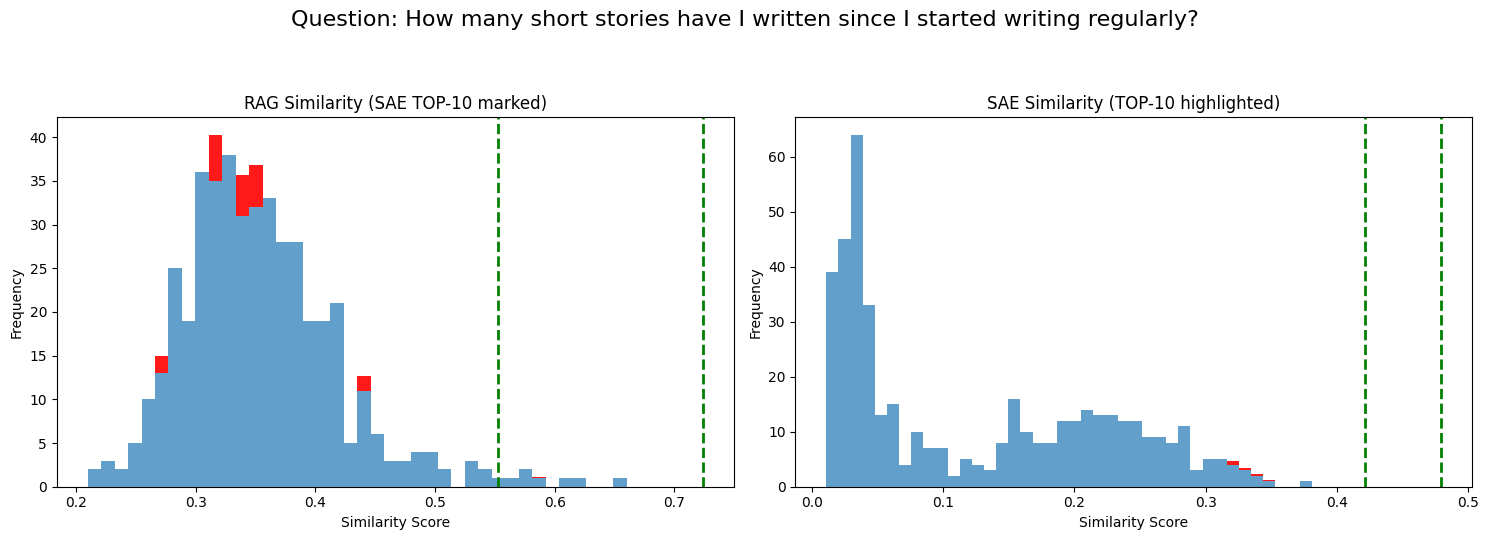


=== TOP 10 MESSAGES BY SAE (no-oracle) ===

[430]  SAE=0.3810   RAG=0.5868
I've been experimenting with different writing styles and formats, including poetry and scriptwriting, and I recently wrote a short poem that I'm really proud of. I was wondering if you could give me some information on submitting to literary magazines.

[165]  SAE=0.3498   RAG=0.3146
What role does computer science play in modeling complex biological systems in biomedicine?

[179]  SAE=0.3409   RAG=0.3508
How do I properly care for my indoor plants?

[223]  SAE=0.3348   RAG=0.3414
What's the average cost to get into these electronic music nightclubs in Miami? Are they expensive?

[181]  SAE=0.3331   RAG=0.3128
Do you think it's better to use natural or artificial light for indoor plants?

[235]  SAE=0.3281   RAG=0.2693
How does the aging process affect the taste of different types of cheese?

[259]  SAE=0.3273   RAG=0.3445
How important is clear communication from the instructor during a Pilates class in ensur

In [22]:
for r in results:
    plot_instance_results(r)

### Grafico RAG vs SAE similarity. Mejor visualización q lo anterior.

In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np

nomic_model = SentenceTransformer(
    "nomic-ai/nomic-embed-text-v1",
    trust_remote_code=True
)

def sae_encode_text(
    model, 
    sae, 
    text, 
    hook_name, 
    prepend_bos=True, 
    method="mean",   # "mean", "max", or "topk"
    k=3):
    
    with torch.no_grad():
        tokens = model.to_tokens(text, prepend_bos=prepend_bos)
        _, cache = model.run_with_cache(tokens, names_filter=[hook_name])
        acts = cache[hook_name]              # [batch, seq, d_model]
        acts_no_bos = acts[:, 1:, :]         # [batch, seq-1, d_model]
        feature_acts = sae.encode(acts_no_bos)  # [batch, seq-1, n_features]

        # ------- Aggregation methods -------
        if method == "mean":
            z = feature_acts.mean(dim=1)     # [B, F]

        elif method == "max":
            z = feature_acts.max(dim=1).values  # [B, F]

        elif method == "topk":
            seq_len = feature_acts.shape[1]
            k_eff = min(k, seq_len)
            topk_vals, _ = torch.topk(feature_acts, k=k_eff, dim=1)
            z = topk_vals.mean(dim=1)        # [B, F]

        else:
            raise ValueError(f"Unknown method '{method}', choose from 'mean', 'max', 'topk'.")

        # Final vector
        z = z.squeeze(0).cpu().numpy()
        return z / np.linalg.norm(z)

<All keys matched successfully>


In [4]:
from collections import defaultdict

# Load dataset
longmemeval_dataset_full = LongMemEvalDataset("short", "investigathon_evaluation")
longmemeval_dataset_full = LongMemEvalDataset("short", "investigathon_held_out")
longmemeval_dataset_full = LongMemEvalDataset("short", "longmemeval")

# Maps: question_id → list of (index, message_count)
id_to_entries = defaultdict(list)

# Scan dataset
for idx, instance in enumerate(longmemeval_dataset_full):
    qid = instance.question_id
    n_msgs = sum(len(sess.messages) for sess in instance.sessions)
    id_to_entries[qid].append((idx, n_msgs))

# Filter to only duplicated IDs
duplicates = {qid: entries for qid, entries in id_to_entries.items() if len(entries) > 1}

# Print results
if not duplicates:
    print("No duplicated question_id values found.")
else:
    print(f"Found {len(duplicates)} duplicated question_id values:\n")
    for qid, entries in duplicates.items():
        print(f"question_id = {qid!r}  (appears {len(entries)} times)")
        for idx, msgcount in entries:
            print(f"  - dataset index: {idx} | message count: {msgcount}")
        print()


Found 12 duplicated question_id values:

question_id = 'gen_2311e44b'  (appears 2 times)
  - dataset index: 6 | message count: 494
  - dataset index: 172 | message count: 493

question_id = 'gen_a96c20ee'  (appears 2 times)
  - dataset index: 10 | message count: 535
  - dataset index: 112 | message count: 489

question_id = 'gen_19b5f2b3'  (appears 2 times)
  - dataset index: 14 | message count: 527
  - dataset index: 118 | message count: 482

question_id = 'gen_ba358f49'  (appears 2 times)
  - dataset index: 30 | message count: 477
  - dataset index: 48 | message count: 409

question_id = 'gen_09ba9854'  (appears 2 times)
  - dataset index: 38 | message count: 479
  - dataset index: 236 | message count: 513

question_id = 'gen_88432d0a'  (appears 2 times)
  - dataset index: 77 | message count: 510
  - dataset index: 188 | message count: 479

question_id = 'gen_15745da0'  (appears 2 times)
  - dataset index: 85 | message count: 547
  - dataset index: 153 | message count: 474

question_

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Assumes these are already defined somewhere:
# - LongMemEvalDataset
# - sae_encode_text
# - sae_base_model
# - sae
# - hook_name
# - nomic_model

longmemeval_dataset_full = LongMemEvalDataset("short", "investigathon_held_out")

results = []   # MASTER LIST

# Global counters for "all-oracle-in-top10" scores
n_questions = 0
rag_all_oracle_questions = 0        # questions where top-10 RAG contains ALL oracle messages
sae_all_oracle_questions = 0        # questions where top-10 SAE contains ALL oracle messages
combined_all_oracle_questions = 0   # questions where top-10 distance contains ALL oracle messages

# Buckets of questions
combined_only = []            # combined correct, RAG & SAE wrong
sae_not_combined = []         # SAE correct, combined wrong (RAG any)
rag_not_combined = []         # RAG correct, combined wrong (SAE any)
sae_not_rag = []              # NEW: SAE correct, RAG wrong (Combined any)

for instance in longmemeval_dataset_full[2:3]:
    n_questions += 1
    print(n_questions)
    question = instance.question
    t_question = instance.t_question

    # --- Embeddings of the question ---
    z_RAG_question = nomic_model.encode(question, convert_to_numpy=True)
    z_SAE_question = sae_encode_text(sae_base_model, sae, question, hook_name)

    answer = instance.answer

    # --- Load SAE embeddings for ALL messages ---
    df_sae = pd.read_parquet(f"data/sae/{instance.question_id}.parquet")
    sae_embeddings = df_sae["embeddings"].tolist()

    # --- Load RAG embeddings for ALL messages ---
    df_rag = pd.read_parquet(f"data/rag/{instance.question_id}.parquet")
    rag_embeddings = df_rag["embeddings"].tolist()


    # RESPUESTAS (oráculo)
    oracle_answers = {
        "dates": [],
        "contents": []
    }

    # SIMILARIDAD para los mensajes que TIENEN rta.
    oracle_SAE_similarity = []
    oracle_RAG_similarity = []

    # SIMILARIDAD para los mensajes que NO tienen rta.
    no_oracle_SAE_similarity = []
    no_oracle_RAG_similarity = []
    no_oracle_contents = []

    idx = 0  # global index over messages
    n_msgs = sum(len(sess.messages) for sess in instance.sessions)
    print(
        "question_id:", instance.question_id,
        "question:", instance.question,
        "messages:", n_msgs,
        "rag_emb:", len(rag_embeddings),
        "sae_emb:", len(sae_embeddings),
    )

    for sess in tqdm(instance.sessions, desc="Sessions"):
        for m in sess.messages:

            # Load precomputed embeddings
            z_RAG_message = rag_embeddings[idx]
            z_SAE_message = sae_embeddings[idx]

            if m.get("has_answer", False):
                # Mensajes que contienen la respuesta (oráculo)
                oracle_answers["dates"].append(sess.date)
                oracle_answers["contents"].append(m["content"])

                oracle_RAG_similarity.append(
                    np.dot(z_RAG_question, z_RAG_message)
                )
                oracle_SAE_similarity.append(
                    np.dot(z_SAE_question, z_SAE_message)
                )
                
                print(oracle_answers["contents"])
            else:
                # Mensajes que NO contienen la respuesta
                no_oracle_RAG_similarity.append(
                    np.dot(z_RAG_question, z_RAG_message)
                )
                no_oracle_SAE_similarity.append(
                    np.dot(z_SAE_question, z_SAE_message)
                )
                no_oracle_contents.append(m["content"])
            idx += 1

    # ----------------------------------------------------------------------
    # EVALUATION: top-10 RAG, top-10 SAE, top-10 combined distance
    # ----------------------------------------------------------------------
    rag_no = np.array(no_oracle_RAG_similarity, dtype=float)
    rag_or = np.array(oracle_RAG_similarity, dtype=float)
    sae_no = np.array(no_oracle_SAE_similarity, dtype=float)
    sae_or = np.array(oracle_SAE_similarity, dtype=float)

    if len(rag_no) + len(rag_or) > 0:
        # Combine all messages (non-oracle first, then oracle)
        rag_all = np.concatenate([rag_no, rag_or])
        sae_all = np.concatenate([sae_no, sae_or])

        # Mask that tells which entries in rag_all/sae_all are oracle
        is_oracle_all = np.concatenate([
            np.zeros_like(rag_no, dtype=bool),
            np.ones_like(rag_or, dtype=bool),
        ])

        k = min(10, len(rag_all))

        # Top-10 by RAG alone (raw similarities)
        top_rag_idx = np.argsort(rag_all)[-k:]

        # Top-10 by SAE alone (raw similarities)
        top_sae_idx = np.argsort(sae_all)[-k:]

        # Top-10 by COMBINED distance (NO normalization)
        distances = np.sqrt(rag_all**2 + sae_all**2)
        top_combined_idx = np.argsort(distances)[-k:]

        # Indices of oracle messages within rag_all/sae_all
        oracle_indices_all = np.where(is_oracle_all)[0]
        n_oracles = len(oracle_indices_all)

        if n_oracles > 0:
            rag_all_oracle_hit = int(np.isin(oracle_indices_all, top_rag_idx).all())
            sae_all_oracle_hit = int(np.isin(oracle_indices_all, top_sae_idx).all())
            combined_all_oracle_hit = int(np.isin(oracle_indices_all, top_combined_idx).all())
        else:
            rag_all_oracle_hit = 0
            sae_all_oracle_hit = 0
            combined_all_oracle_hit = 0
    else:
        # No messages at all
        rag_all = sae_all = np.array([])
        is_oracle_all = np.array([], dtype=bool)
        oracle_indices_all = np.array([], dtype=int)
        n_oracles = 0
        rag_all_oracle_hit = 0
        sae_all_oracle_hit = 0
        combined_all_oracle_hit = 0

    # Update global counts
    rag_all_oracle_questions       += rag_all_oracle_hit
    sae_all_oracle_questions       += sae_all_oracle_hit
    combined_all_oracle_questions  += combined_all_oracle_hit

    # ---------- Buckets ----------
    # 1) Combined-only: combined correct, RAG & SAE wrong
    if combined_all_oracle_hit and not rag_all_oracle_hit and not sae_all_oracle_hit:
        combined_only.append({
            "question_id": instance.question_id,
            "question": question,
            "oracle_answers": oracle_answers["contents"],
        })

    # 2) SAE worked but combined did NOT (RAG can be anything)
    if sae_all_oracle_hit and not combined_all_oracle_hit:
        sae_not_combined.append({
            "question_id": instance.question_id,
            "question": question,
            "oracle_answers": oracle_answers["contents"],
        })

    # 3) RAG worked but combined did NOT (SAE can be anything)
    if rag_all_oracle_hit and not combined_all_oracle_hit:
        rag_not_combined.append({
            "question_id": instance.question_id,
            "question": question,
            "oracle_answers": oracle_answers["contents"],
        })

    # 4) NEW: SAE worked and RAG did NOT (combined can be anything)
    if sae_all_oracle_hit and not rag_all_oracle_hit:
        sae_not_rag.append({
            "question_id": instance.question_id,
            "question": question,
            "oracle_answers": oracle_answers["contents"],
        })

    # ----------------------------------------------------------------------
    # SAVE RESULTS
    # ----------------------------------------------------------------------
    results.append({
        "question": question,
        "t_question": t_question,
        "answer": answer,
        "question_id": instance.question_id,
        "oracle_answers": oracle_answers,
        "oracle_SAE_similarity": oracle_SAE_similarity,
        "oracle_RAG_similarity": oracle_RAG_similarity,
        "no_oracle_SAE_similarity": no_oracle_SAE_similarity,
        "no_oracle_RAG_similarity": no_oracle_RAG_similarity,
        "no_oracle_contents": no_oracle_contents,
        # per-question "all-oracle-in-top10" flags
        "RAG_all_oracle_hit": rag_all_oracle_hit,
        "SAE_all_oracle_hit": sae_all_oracle_hit,
        "Combined_all_oracle_hit": combined_all_oracle_hit,
        # number of oracle messages for this question (for debugging)
        "n_oracles": n_oracles,
    })

# ----------------------------------------------------------------------
# GLOBAL SCORES: normalized by number of questions
# ----------------------------------------------------------------------
print("\n=== All-oracle-in-top10 scores (normalized by #questions) ===")
print(f"Total questions: {n_questions}")

if n_questions > 0:
    print(f"RAG@10 (top-10 RAG contains ALL oracle messages): "
          f"{rag_all_oracle_questions}/{n_questions} = {rag_all_oracle_questions / n_questions:.3f}")
    print(f"SAE@10 (top-10 SAE contains ALL oracle messages): "
          f"{sae_all_oracle_questions}/{n_questions} = {sae_all_oracle_questions / n_questions:.3f}")
    print(f"Combined@10 (top-10 combined distance contains ALL oracle messages): "
          f"{combined_all_oracle_questions}/{n_questions} = {combined_all_oracle_questions / n_questions:.3f}")
else:
    print("No questions processed.")

# ----------------------------------------------------------------------
# DETAILED LISTS WITH ORACLE ANSWERS
# ----------------------------------------------------------------------
def print_bucket(title, bucket):
    print(f"\n=== {title}: {len(bucket)} questions ===")
    for q in bucket:
        print(f"\n[question_id: {q['question_id']}]")
        print("Question:")
        print(q["question"])
        print("Oracle answers:")
        for i, ans in enumerate(q["oracle_answers"], 1):
            print(f"  {i}. {ans}")

print_bucket(
    "Combined-only (combined correct, RAG & SAE wrong)",
    combined_only
)

print_bucket(
    "SAE worked but Combined did NOT (RAG any)",
    sae_not_combined
)

print_bucket(
    "RAG worked but Combined did NOT (SAE any)",
    rag_not_combined
)

print_bucket(
    "SAE worked but RAG did NOT (Combined any)",
    sae_not_rag
)


1
question_id: gen_gpt4_93f6379c question: Which trip did I plan first: bike road trip, Costa Rica, or Barcelona? messages: 445 rag_emb: 445 sae_emb: 445


Sessions: 100%|██████████| 42/42 [00:00<00:00, 5704.32it/s]

['I\'m looking for some book recommendations. I just joined a new book club group called "Page Turners" last week, where we discuss our favorite novels and share recommendations. Do you have any suggestions for our next read?']
['I\'m looking for some book recommendations. I just joined a new book club group called "Page Turners" last week, where we discuss our favorite novels and share recommendations. Do you have any suggestions for our next read?', 'I\'m looking for some marketing resources on personal branding. I\'ve been engaging with a group called "Marketing Professionals" on LinkedIn since I joined it yesterday, where we discuss industry trends and share resources. Do you know of any good articles or online courses on the topic?']

=== All-oracle-in-top10 scores (normalized by #questions) ===
Total questions: 1
RAG@10 (top-10 RAG contains ALL oracle messages): 0/1 = 0.000
SAE@10 (top-10 SAE contains ALL oracle messages): 0/1 = 0.000
Combined@10 (top-10 combined distance contain

In [9]:
print("\n=== All-oracle-in-top10 scores (normalized by #questions) ===")
print(f"Total questions: {n_questions}")

if n_questions > 0:
    print(f"RAG@10 (top-10 RAG contains ALL oracle messages): "
          f"{rag_all_oracle_questions}/{n_questions} = {rag_all_oracle_questions / n_questions:.3f}")
    print(f"SAE@10 (top-10 SAE contains ALL oracle messages): "
          f"{sae_all_oracle_questions}/{n_questions} = {sae_all_oracle_questions / n_questions:.3f}")
    print(f"Combined@10 (top-10 combined distance contains ALL oracle messages): "
          f"{combined_all_oracle_questions}/{n_questions} = {combined_all_oracle_questions / n_questions:.3f}")
else:
    print("No questions processed.")

# ----------------------------------------------------------------------
# DETAILED LISTS WITH ORACLE ANSWERS
# ----------------------------------------------------------------------
def print_bucket(title, bucket):
    print(f"\n=== {title}: {len(bucket)} questions ===")
    for q in bucket:
        print(f"\n[question_id: {q['question_id']}]")
        print("Question:")
        print(q["question"])
        print("Oracle answers:")
        for i, ans in enumerate(q["oracle_answers"], 1):
            print(f"  {i}. {ans}")

print_bucket(
    "Combined-only (combined correct, RAG & SAE wrong)",
    combined_only
)

print_bucket(
    "SAE worked but Combined did NOT (RAG any)",
    sae_not_combined
)

print_bucket(
    "RAG worked but Combined did NOT (SAE any)",
    rag_not_combined
)

print_bucket(
    "SAE worked but RAG did NOT (Combined any)",
    sae_not_rag
)


=== All-oracle-in-top10 scores (normalized by #questions) ===
Total questions: 250
RAG@10 (top-10 RAG contains ALL oracle messages): 0/250 = 0.000
SAE@10 (top-10 SAE contains ALL oracle messages): 1/250 = 0.004
Combined@10 (top-10 combined distance contains ALL oracle messages): 1/250 = 0.004

=== Combined-only (combined correct, RAG & SAE wrong): 0 questions ===

=== SAE worked but Combined did NOT (RAG any): 0 questions ===

=== RAG worked but Combined did NOT (SAE any): 0 questions ===

=== SAE worked but RAG did NOT (Combined any): 1 questions ===

[question_id: gen_0bc8ad93]
Question:
Which trip did I plan first: Jordan, Ireland, or Zurich?
Oracle answers:
  1. I'm planning a trip to Jordan and I'm really interested in visiting Petra. Can you tell me more about the history of the city and its significance? By the way, I just learned a lot about it in a lecture at the History Museum about ancient civilizations this month.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rag_vs_sae(result):
    """
    Scatter plot: RAG similarity vs SAE similarity
    - Grey: non-oracle
    - Green: oracle
    - Red X: 10 farthest points from origin
    - Vertical line: threshold for top 10 highest RAG values
    - Horizontal line: threshold for top 10 highest SAE values
    """

    # Extract arrays
    rag_no = np.array(result["no_oracle_RAG_similarity"])
    sae_no = np.array(result["no_oracle_SAE_similarity"])

    rag_or = np.array(result["oracle_RAG_similarity"])
    sae_or = np.array(result["oracle_SAE_similarity"])

    question = result["question"]

    # -----------------------------
    # Combine ALL points
    # -----------------------------
    rag_all = np.concatenate([rag_no, rag_or])
    sae_all = np.concatenate([sae_no, sae_or])

    # -----------------------------
    # Compute distances & select top-10 farthest
    # -----------------------------
    distances = np.sqrt(rag_all**2 + sae_all**2)
    k = min(10, len(distances))
    farthest_idx = np.argsort(distances)[-k:]

    # -----------------------------
    # Compute top-10 highest RAG and SAE values
    # -----------------------------
    top10_rag_idx = np.argsort(rag_all)[-k:]
    rag_threshold = np.min(rag_all[top10_rag_idx])   # vertical line at this value

    top10_sae_idx = np.argsort(sae_all)[-k:]
    sae_threshold = np.min(sae_all[top10_sae_idx])   # horizontal line at this value

    # -----------------------------
    # PLOT
    # -----------------------------
    plt.figure(figsize=(7, 6))
    plt.title(f"RAG vs SAE similarity\n{question}", fontsize=14)

    # Non-oracle (grey)
    plt.scatter(rag_no, sae_no, alpha=0.4, label="non-oracle", s=20)

    # Oracle (green)
    if len(rag_or) > 0:
        plt.scatter(rag_or, sae_or, color="green", s=60, label="oracle messages")

    # Farthest 10 (red X)
    plt.scatter(
        rag_all[farthest_idx],
        sae_all[farthest_idx],
        color="red",
        s=90,
        marker="x",
        linewidths=2.5,
        label="10 farthest points"
    )

    # Axes lines
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    # -----------------------------
    # Top-10 RAG & SAE threshold lines
    # -----------------------------
    plt.axvline(rag_threshold, color='blue', linestyle='--',
                label=f"Top 10 RAG threshold = {rag_threshold:.3f}")

    plt.axhline(sae_threshold, color='purple', linestyle='--',
                label=f"Top 10 SAE threshold = {sae_threshold:.3f}")

    plt.xlabel("RAG similarity")
    plt.ylabel("SAE similarity")
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


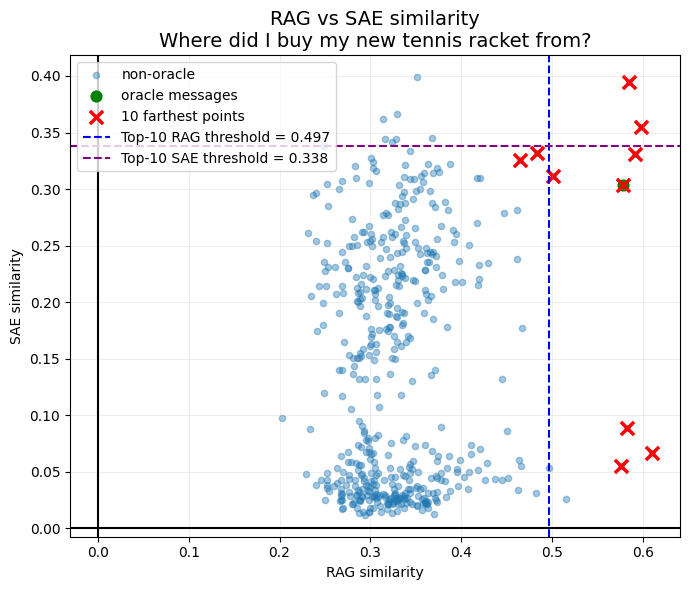

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       1/1  (oracle messages in top-10 SAE: 2)
  Combined@10:  1/1  (oracle messages in top-10 distance: 2)


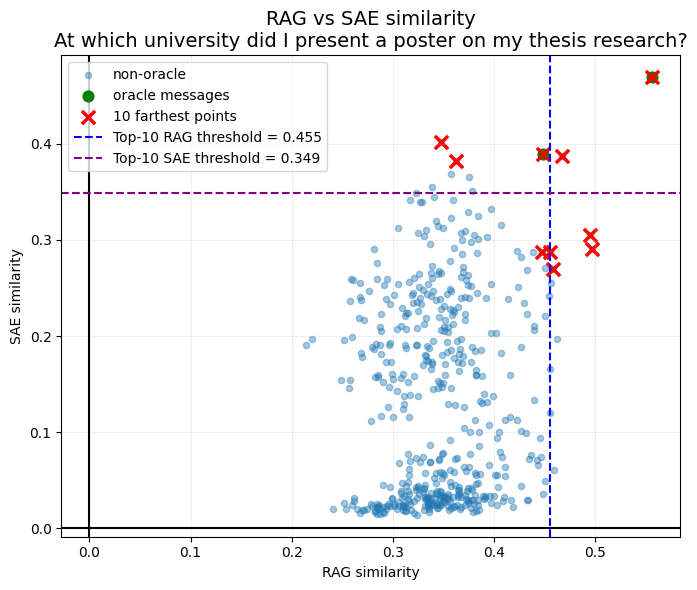

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 2)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


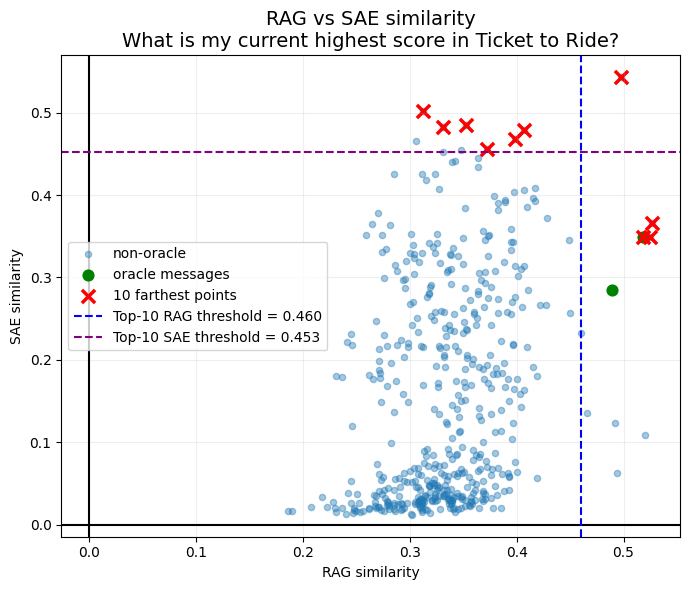

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 3)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 3)


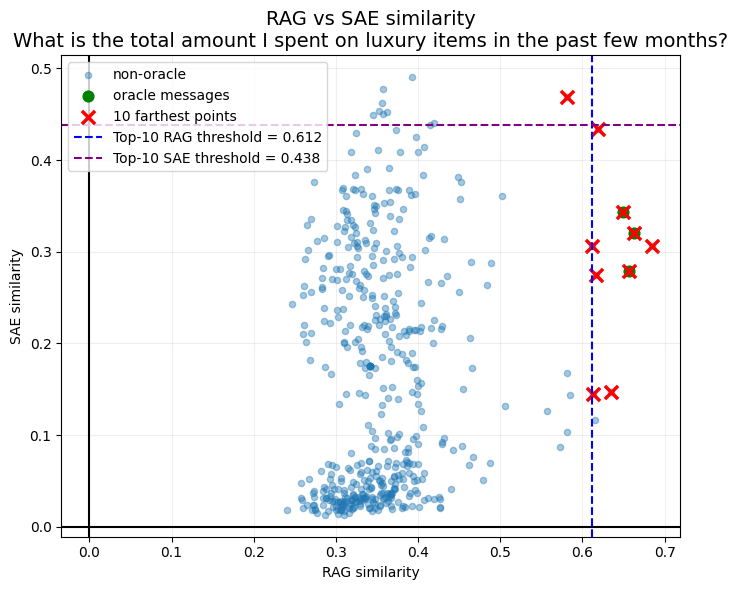

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 2)
  SAE@10:       1/1  (oracle messages in top-10 SAE: 1)
  Combined@10:  1/1  (oracle messages in top-10 distance: 2)


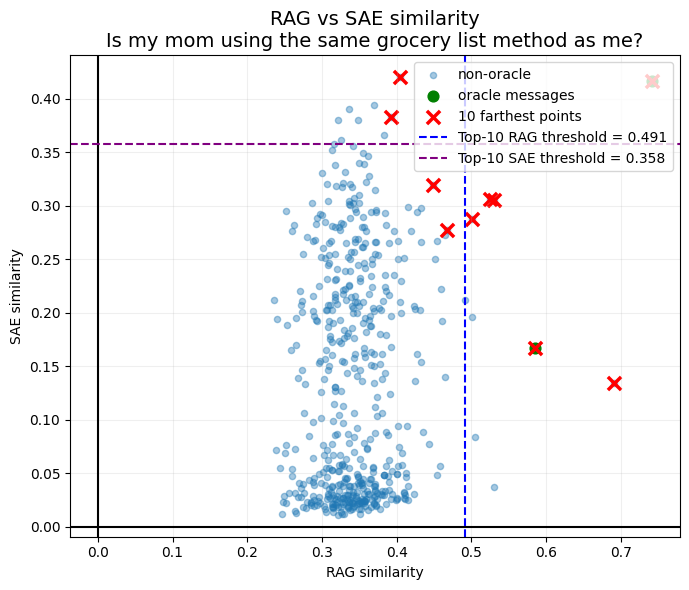

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 2)
  SAE@10:       1/1  (oracle messages in top-10 SAE: 2)
  Combined@10:  1/1  (oracle messages in top-10 distance: 2)


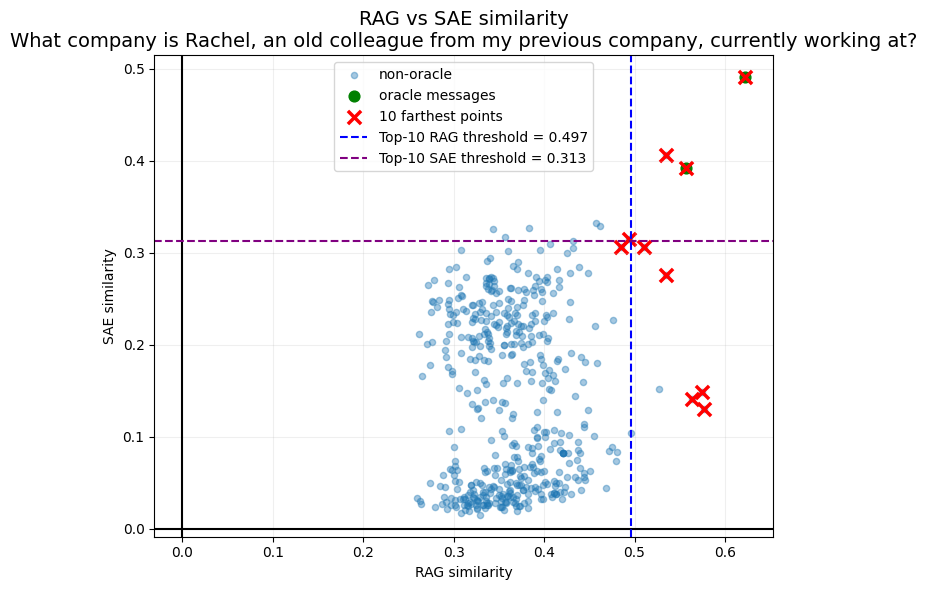

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       1/1  (oracle messages in top-10 SAE: 1)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


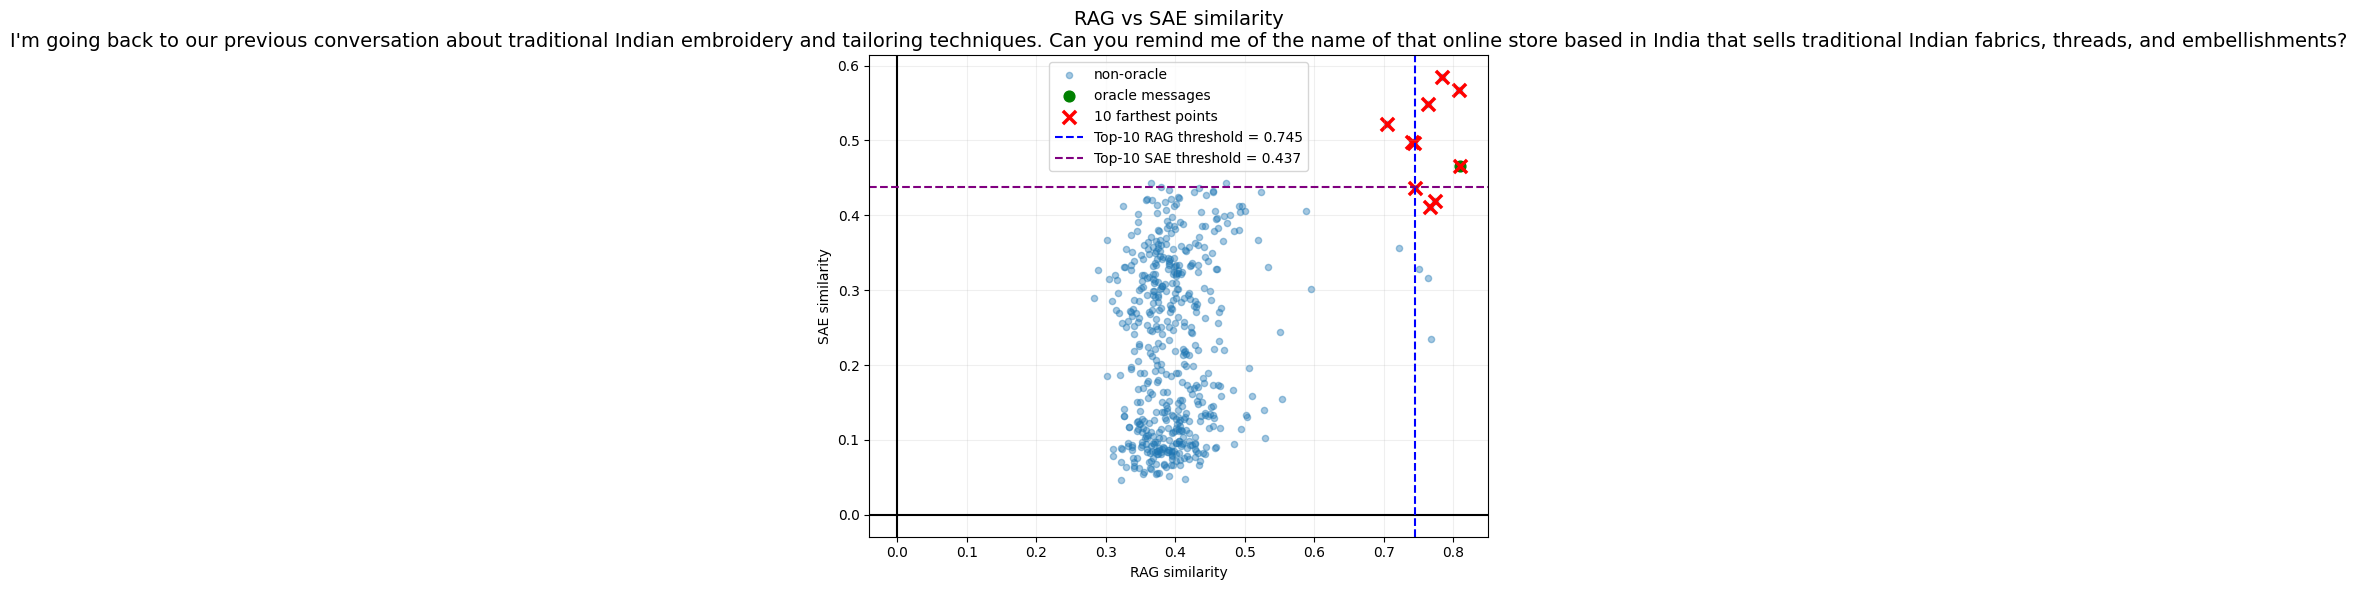

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       0/1  (oracle messages in top-10 RAG: 0)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


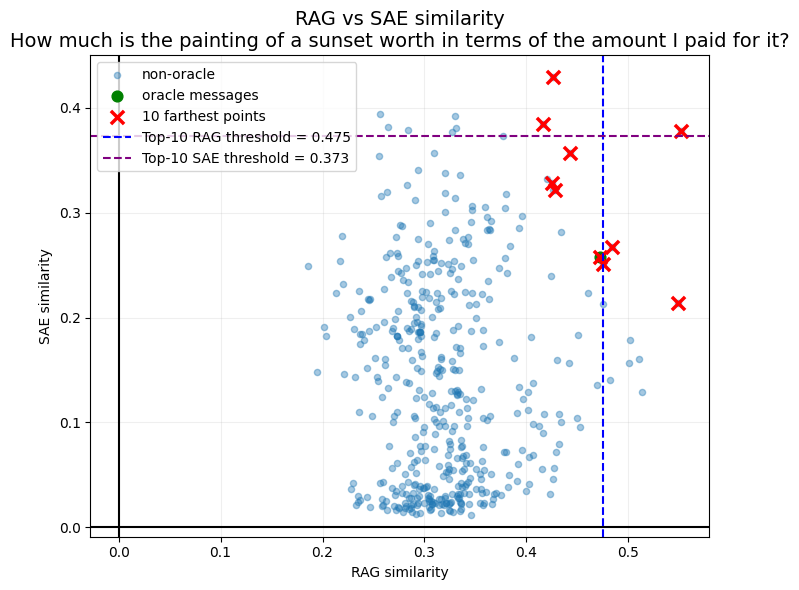

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       1/1  (oracle messages in top-10 SAE: 1)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


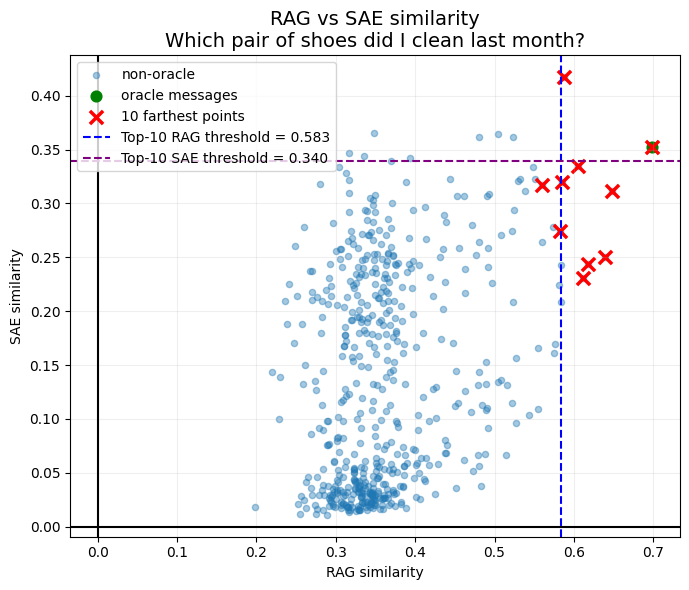

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 2)
  SAE@10:       1/1  (oracle messages in top-10 SAE: 1)
  Combined@10:  1/1  (oracle messages in top-10 distance: 2)


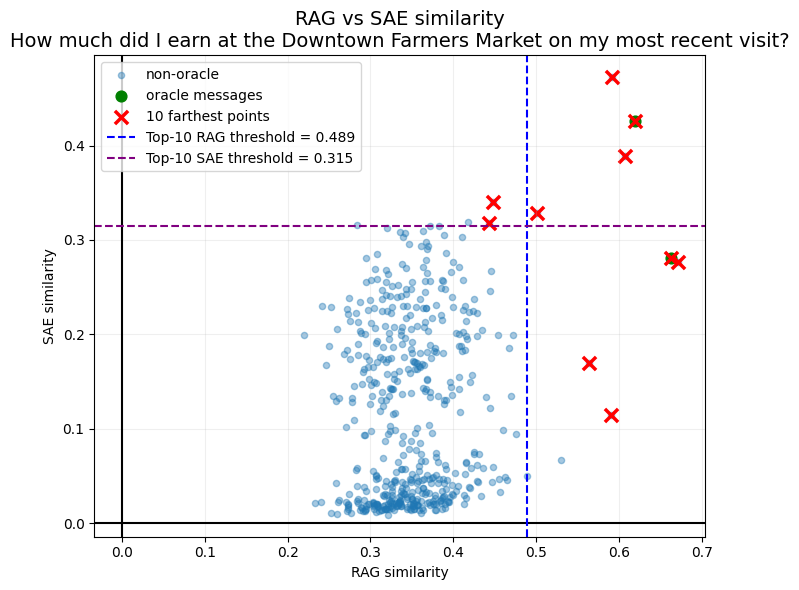

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


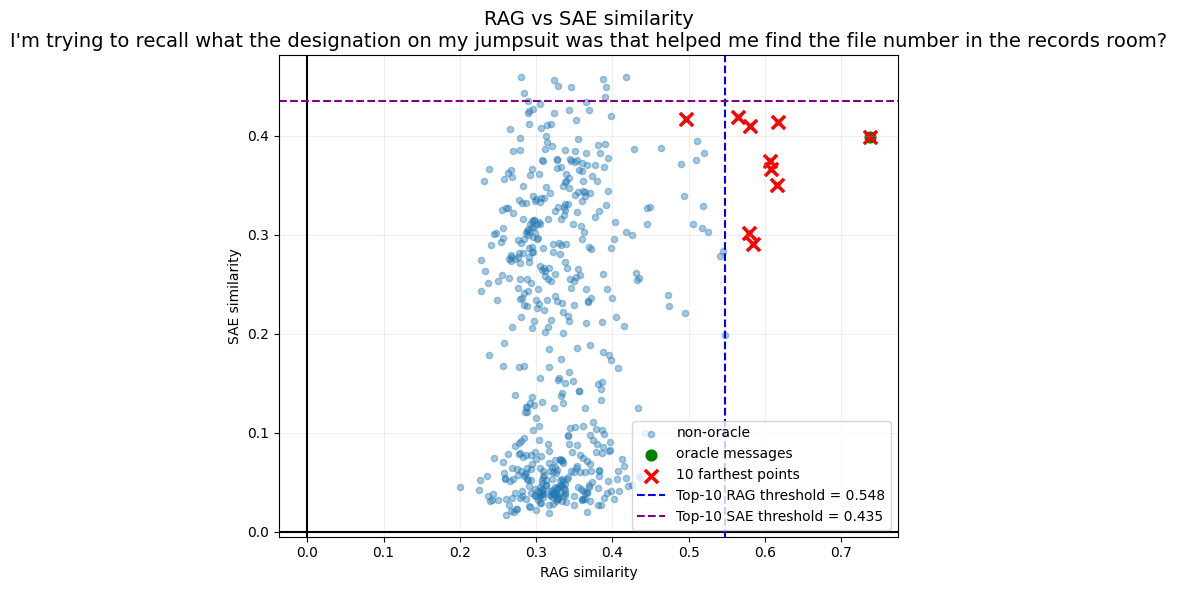

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


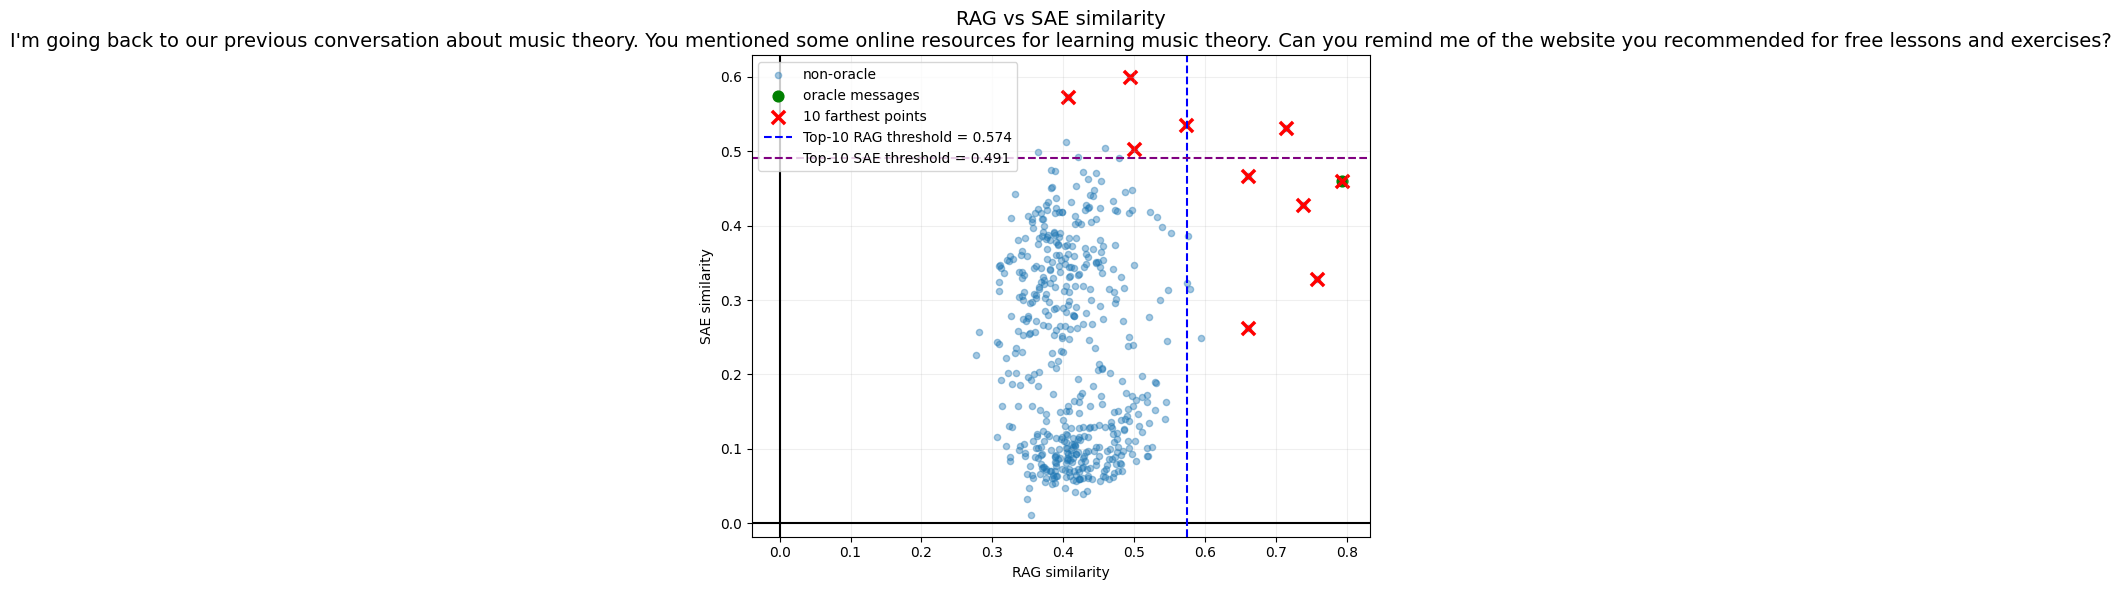

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       1/1  (oracle messages in top-10 SAE: 1)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


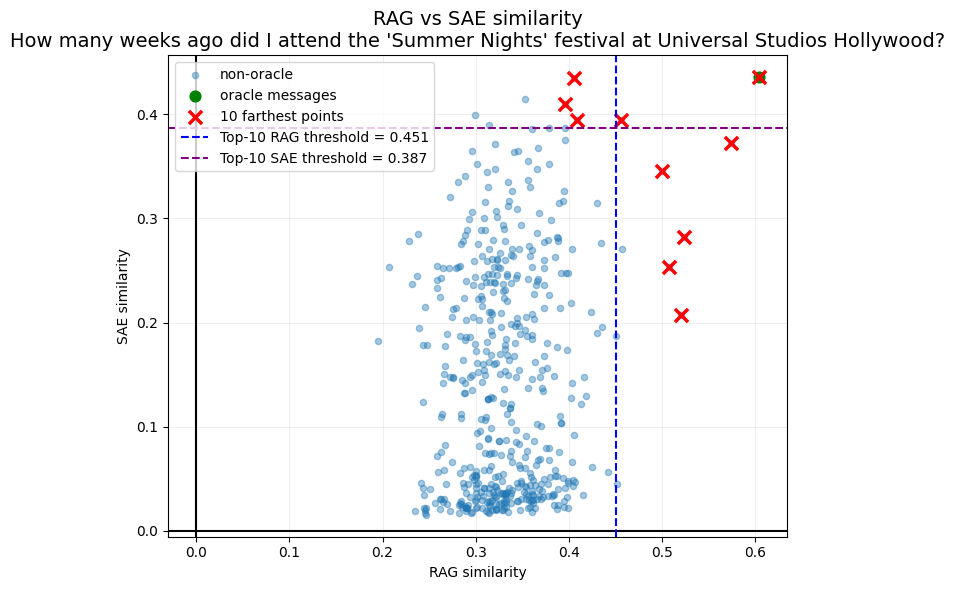

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 2)


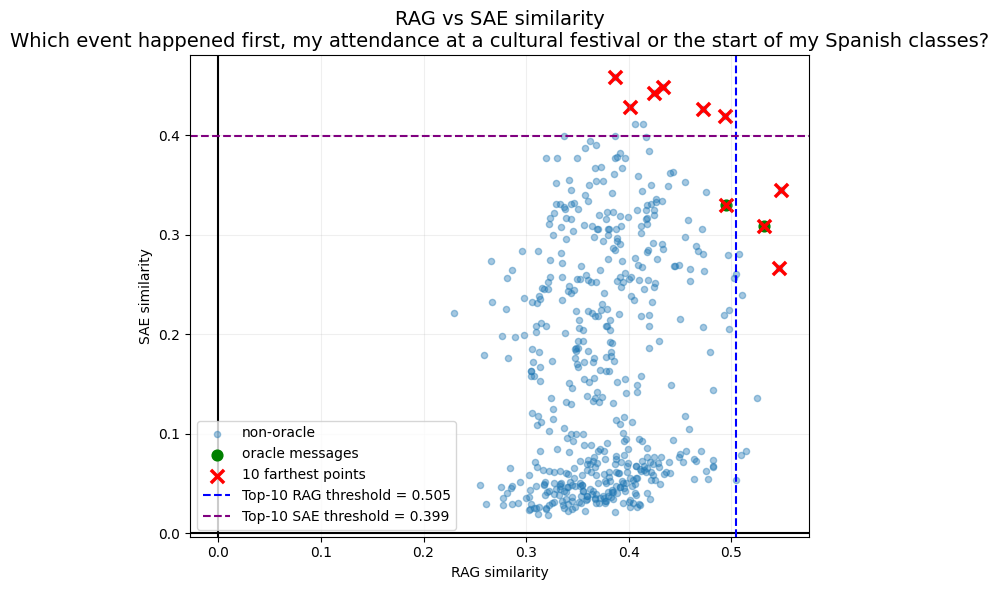

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


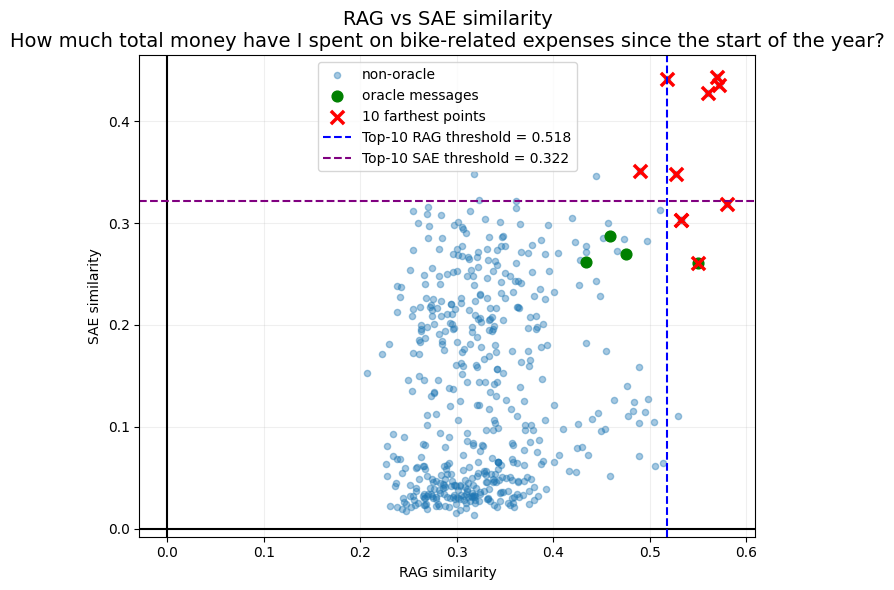

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


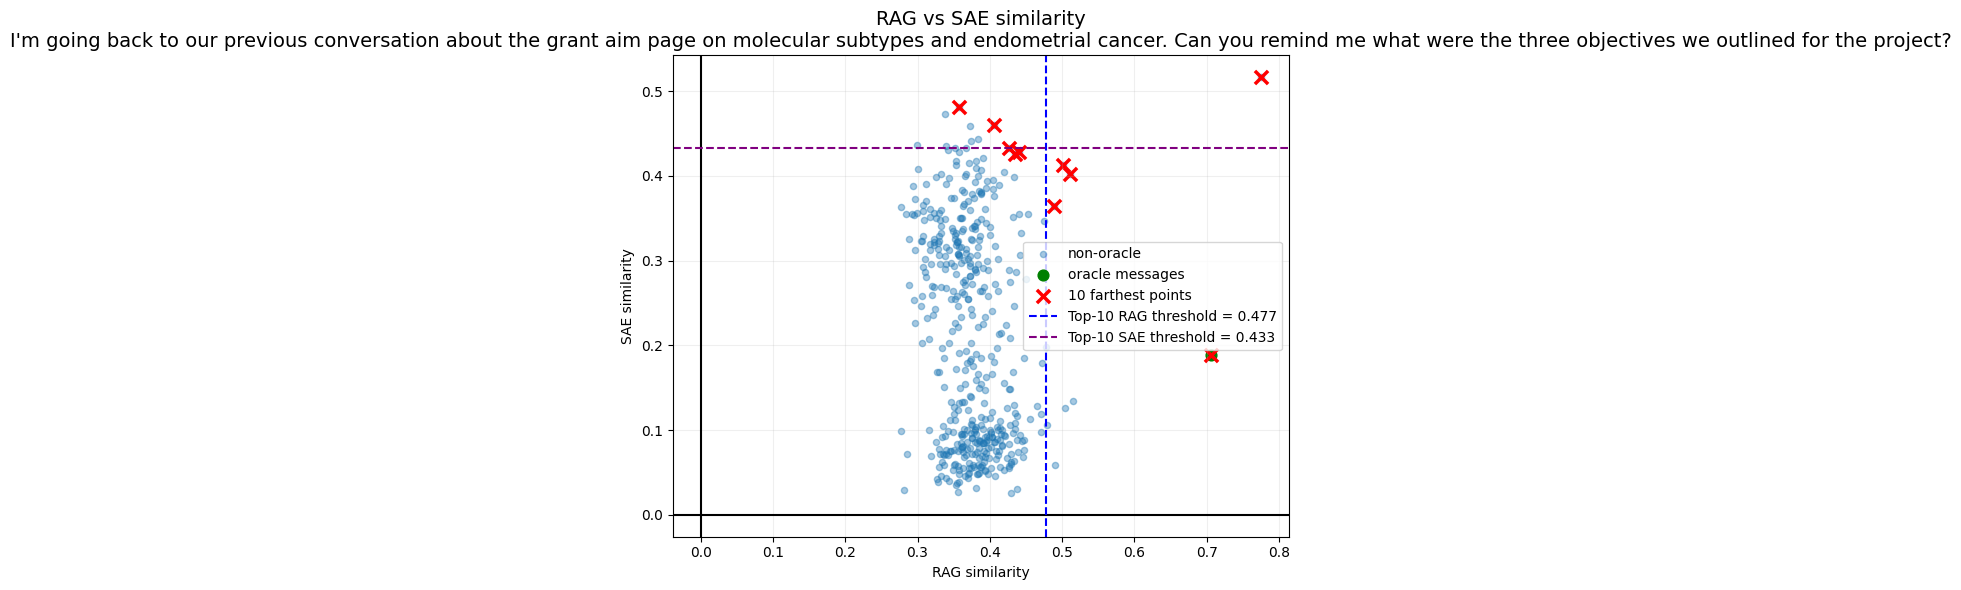

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


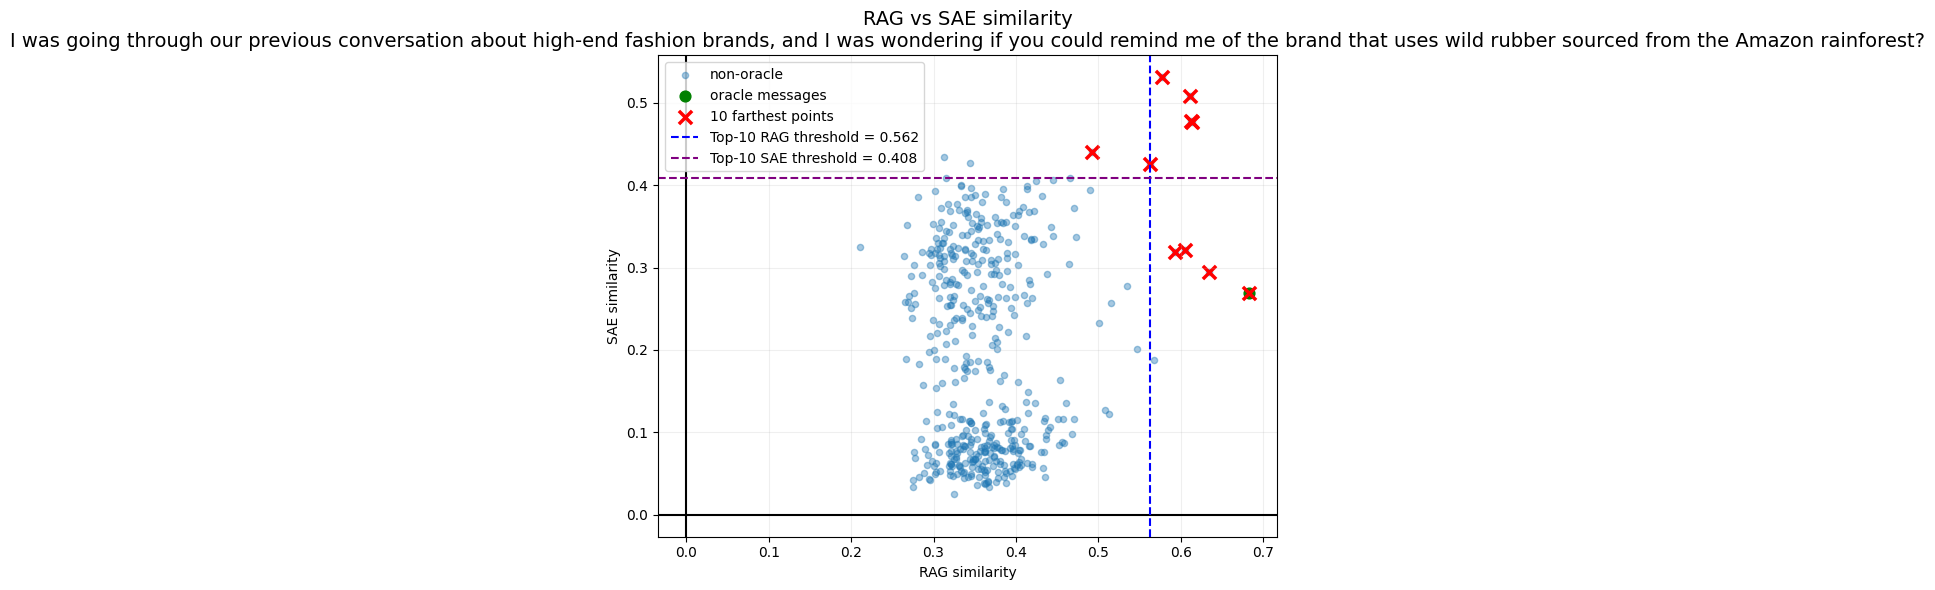

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 2)


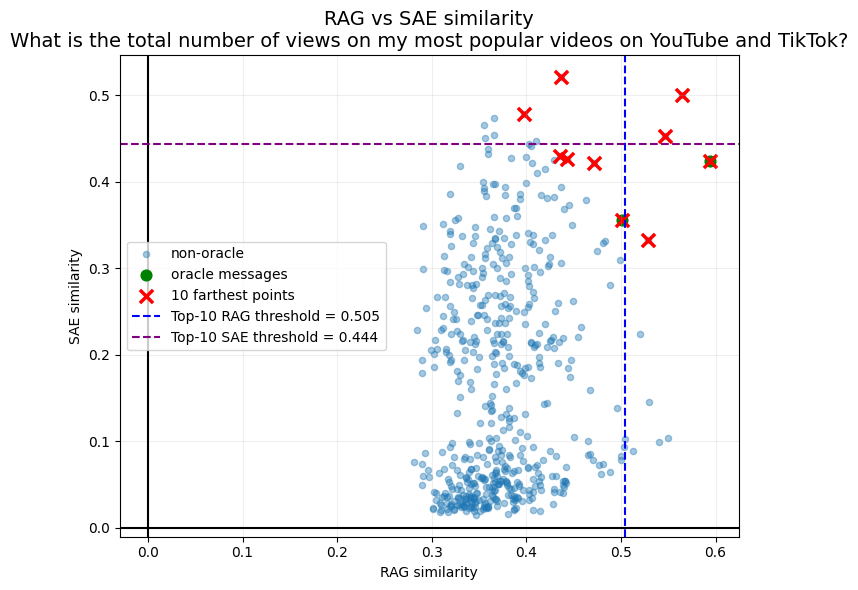

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 2)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


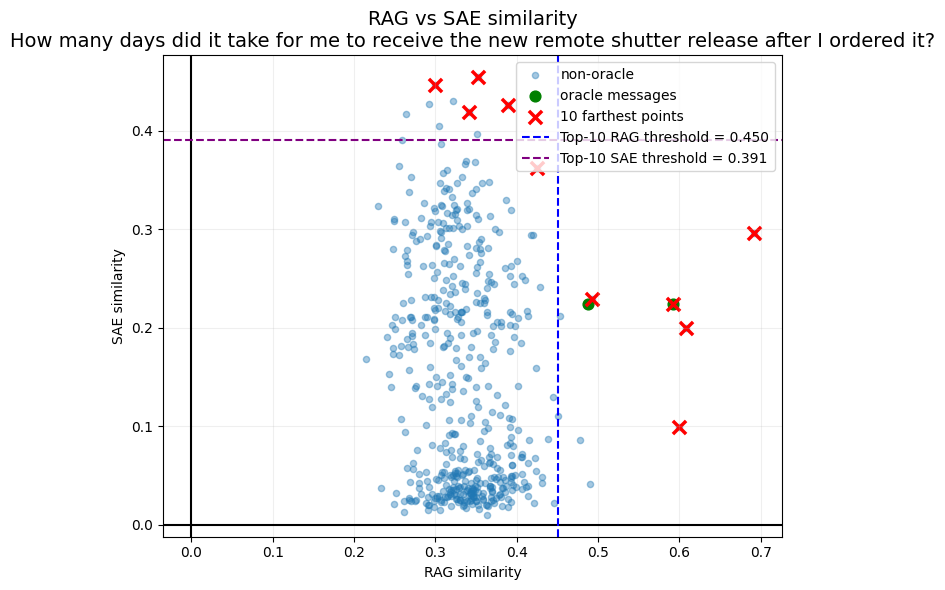

Oracle presence in top-10 (per-question hit scores):
  RAG@10:       1/1  (oracle messages in top-10 RAG: 1)
  SAE@10:       0/1  (oracle messages in top-10 SAE: 0)
  Combined@10:  1/1  (oracle messages in top-10 distance: 1)


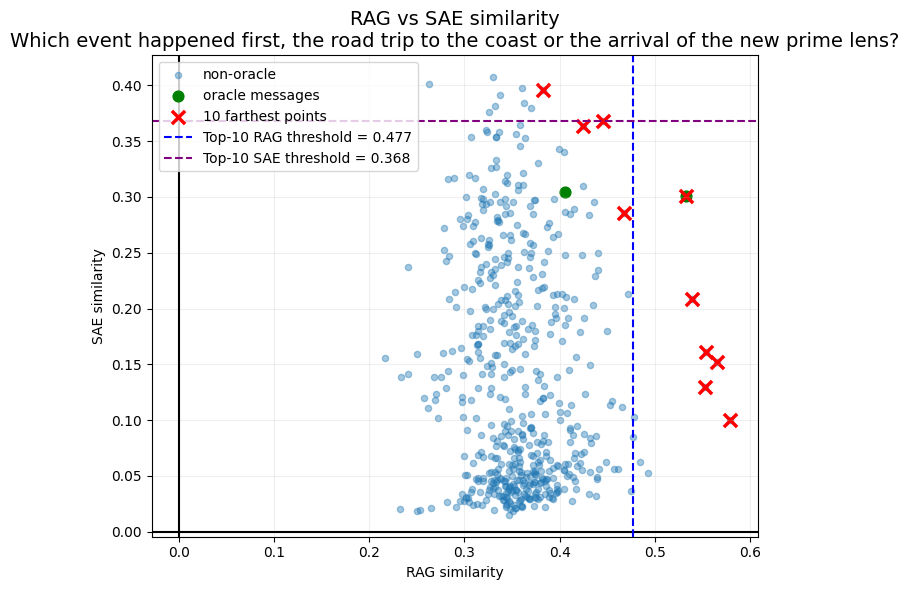

In [23]:
for r in results:
    plot_rag_vs_sae(r)

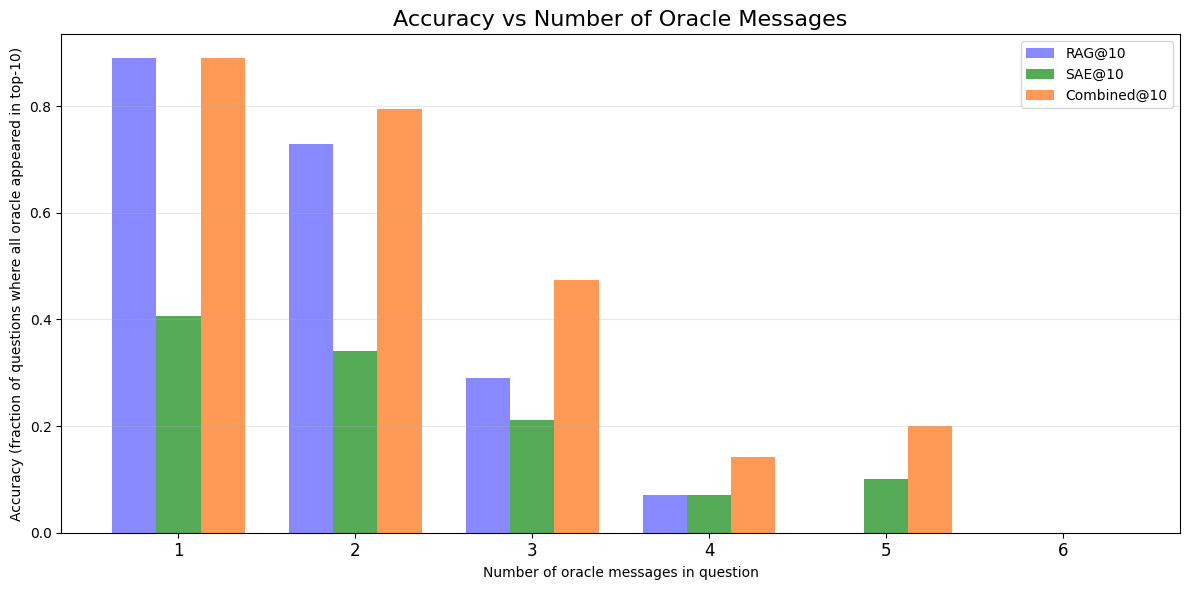

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sorted buckets
n_vals = sorted(by_n_oracles.keys())

rag_scores = []
sae_scores = []
combined_scores = []

for n in n_vals:
    entry = by_n_oracles[n]
    c = entry["count"]
    rag_scores.append(entry["rag_hits"] / c)
    sae_scores.append(entry["sae_hits"] / c)
    combined_scores.append(entry["combined_hits"] / c)

# --- Plot ---
x = np.arange(len(n_vals))  # bucket positions
width = 0.25

plt.figure(figsize=(12, 6))
plt.title("Accuracy vs Number of Oracle Messages", fontsize=16)

plt.bar(x - width, rag_scores, width, label="RAG@10", color="#8888ff")
plt.bar(x, sae_scores, width, label="SAE@10", color="#55aa55")
plt.bar(x + width, combined_scores, width, label="Combined@10", color="#ff9955")

plt.xticks(x, n_vals, fontsize=12)
plt.ylabel("Accuracy (fraction of questions where all oracle appeared in top-10)")
plt.xlabel("Number of oracle messages in question")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


# UMAP

Visualizing session for question_id=3ba21379
Question:
What type of vehicle model am I currently working on?

Answer:
Ford F-150 pickup truck

Loaded 431 messages for this session.


Rebuilding oracle mask from dataset: 100%|██████████| 44/44 [00:00<00:00, 165218.78it/s]

Number of oracle messages: 2



/home/ubuntu/investigaton-NLP/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ubuntu/investigaton-NLP/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


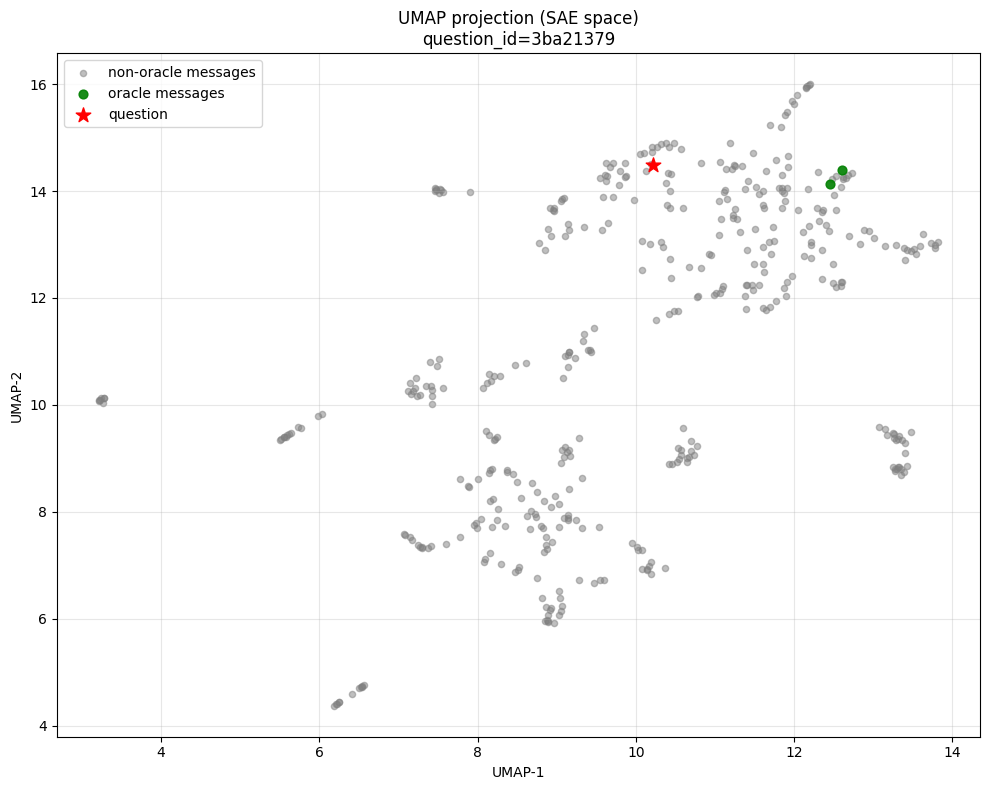

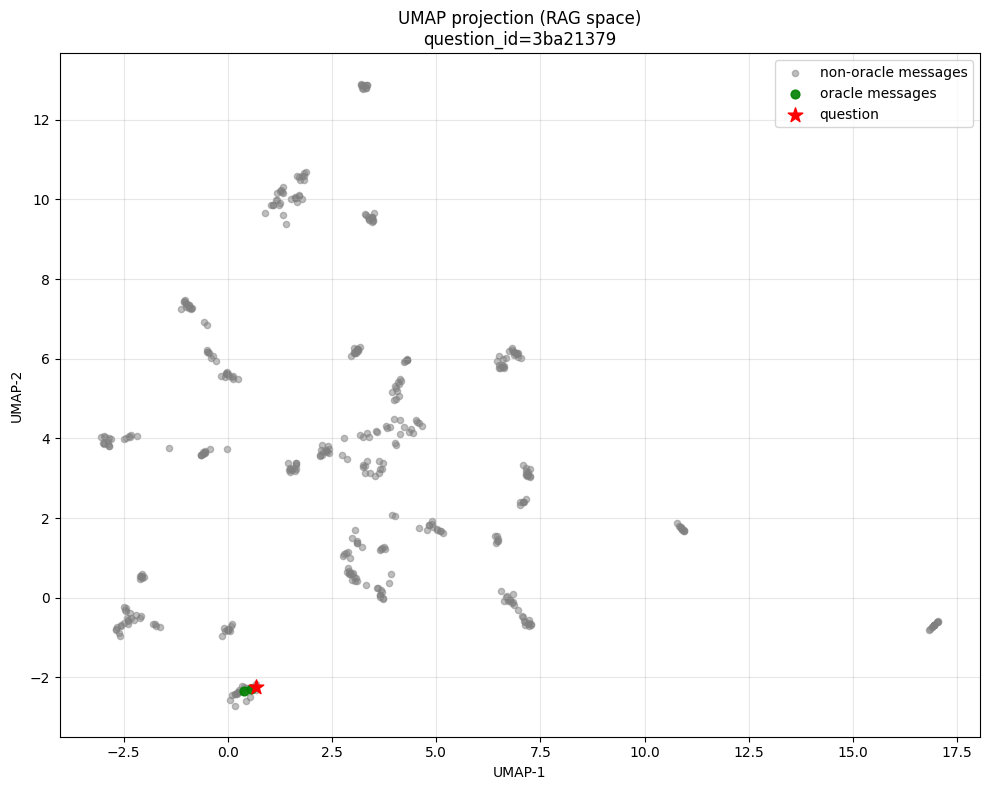

In [36]:
import os
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assumes these are already defined / imported:
# - LongMemEvalDataset
# - sae_encode_text
# - sae_base_model
# - sae
# - hook_name
# - nomic_model

# -----------------------------
# CONFIG
# -----------------------------
SAE_RESULTS_DIR = "data/sae"
RAG_RESULTS_DIR = "data/rag"

# Choose a single question/session to visualize
QUESTION_ID = "3ba21379"  # change this to whichever question_id you want

# -----------------------------
# LOAD DATASET & FIND INSTANCE
# -----------------------------
longmemeval_dataset_full = LongMemEvalDataset("short", "longmemeval")

instance = None
for inst in longmemeval_dataset_full:
    if inst.question_id == QUESTION_ID:
        instance = inst
        break

if instance is None:
    raise ValueError(f"Question id {QUESTION_ID} not found in LongMemEvalDataset.")

question = instance.question
answer = instance.answer

print(f"Visualizing session for question_id={QUESTION_ID}")
print("Question:")
print(question)
print("\nAnswer:")
print(answer)
print()

# -----------------------------
# EMBEDDINGS FOR QUESTION
# -----------------------------
z_RAG_question = nomic_model.encode(question, convert_to_numpy=True)
z_SAE_question = sae_encode_text(sae_base_model, sae, question, hook_name)

# -----------------------------
# LOAD SAE & RAG PARQUETS
# -----------------------------
sae_path = os.path.join(SAE_RESULTS_DIR, f"{QUESTION_ID}.parquet")
rag_path = os.path.join(RAG_RESULTS_DIR, f"{QUESTION_ID}.parquet")

df_sae = pd.read_parquet(sae_path)
df_rag = pd.read_parquet(rag_path)

sae_embeddings = df_sae["embeddings"].to_numpy()
rag_embeddings = df_rag["embeddings"].to_numpy()

# They should have the same number of messages and the same ordering
if len(sae_embeddings) != len(rag_embeddings):
    raise ValueError("SAE and RAG parquet files have different lengths!")

num_messages = len(sae_embeddings)
print(f"Loaded {num_messages} messages for this session.")

# -----------------------------
# BUILD ORACLE MASK (ONE BOOL PER MESSAGE)
# -----------------------------
oracle_mask = []
messages_flat = []

idx = 0
for sess in tqdm(instance.sessions, desc="Rebuilding oracle mask from dataset"):
    for m in sess.messages:
        if idx >= num_messages:
            raise ValueError("More messages in dataset than rows in parquet!")
        has_answer = m.get("has_answer", False)
        oracle_mask.append(bool(has_answer))
        messages_flat.append(m["content"])
        idx += 1

if idx != num_messages:
    raise ValueError(
        f"Mismatch: walked {idx} messages in dataset but parquet has {num_messages} rows."
    )

oracle_mask = np.array(oracle_mask, dtype=bool)

print(f"Number of oracle messages: {oracle_mask.sum()}")

# -----------------------------
# STACK SAE & RAG VECTORS + QUESTION
# -----------------------------
# SAE
X_sae = np.vstack(list(sae_embeddings) + [z_SAE_question])  # (N+1, D_sae)
# RAG
X_rag = np.vstack(list(rag_embeddings) + [z_RAG_question])  # (N+1, D_rag)

# Indices
msg_indices = np.arange(num_messages)      # 0..N-1
question_idx = num_messages                # last row is the question

# -----------------------------
# UMAP PROJECTIONS
# -----------------------------
umap_model_sae = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
X_sae_2d = umap_model_sae.fit_transform(X_sae)

umap_model_rag = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
X_rag_2d = umap_model_rag.fit_transform(X_rag)

# -----------------------------
# PLOT SAE SPACE
# -----------------------------
plt.figure(figsize=(10, 8))

# Non-oracle messages
non_oracle_idx = msg_indices[~oracle_mask]
plt.scatter(
    X_sae_2d[non_oracle_idx, 0],
    X_sae_2d[non_oracle_idx, 1],
    s=20,
    alpha=0.5,
    label="non-oracle messages",
    color="gray",
)

# Oracle messages
oracle_idx = msg_indices[oracle_mask]
if len(oracle_idx) > 0:
    plt.scatter(
        X_sae_2d[oracle_idx, 0],
        X_sae_2d[oracle_idx, 1],
        s=40,
        alpha=0.9,
        label="oracle messages",
        color="green",
    )

# Question
plt.scatter(
    X_sae_2d[question_idx, 0],
    X_sae_2d[question_idx, 1],
    s=120,
    marker="*",
    color="red",
    label="question",
)

plt.title(f"UMAP projection (SAE space)\nquestion_id={QUESTION_ID}")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# PLOT RAG SPACE
# -----------------------------
plt.figure(figsize=(10, 8))

# Non-oracle messages
plt.scatter(
    X_rag_2d[non_oracle_idx, 0],
    X_rag_2d[non_oracle_idx, 1],
    s=20,
    alpha=0.5,
    label="non-oracle messages",
    color="gray",
)

# Oracle messages
if len(oracle_idx) > 0:
    plt.scatter(
        X_rag_2d[oracle_idx, 0],
        X_rag_2d[oracle_idx, 1],
        s=40,
        alpha=0.9,
        label="oracle messages",
        color="green",
    )

# Question
plt.scatter(
    X_rag_2d[question_idx, 0],
    X_rag_2d[question_idx, 1],
    s=120,
    marker="*",
    color="red",
    label="question",
)

plt.title(f"UMAP projection (RAG space)\nquestion_id={QUESTION_ID}")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
